# Rule Generation Using LLM

In [1]:
# installing the necessary modules
!pip3 install requests
!pip3 install html5lib
!pip3 install bs4
!pip3 install openai==0.28
!pip3 install tiktoken

  Preparing metadata (setup.py) ... done
  Created wheel for bs4: filename=bs4-0.0.1-py3-none-any.whl size=1256 sha256=dbcda528710fdc0817708c2124fc284e0868da8cf53c9d865b060cade3e881b9
  Stored in directory: /root/.cache/pip/wheels/25/42/45/b773edc52acb16cd2db4cf1a0b47117e2f69bb4eb300ed0e70
Successfully built bs4
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 1.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llmx 0.0.15a0 requires cohere, which is not installed.
llmx 0.0.15a0 requires tiktoken, which is not installed.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 23.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llmx 0.0.15a0 requires cohere, which is not installed.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Dataset Preparation

**Converting the RASE TAGGED HTML Rules to NLT(Natural Language Text) Rules**

In [3]:
import requests
from bs4 import BeautifulSoup
from bs4 import BeautifulSoup, Tag
import re
import openai
import tiktoken

In [4]:
from io import StringIO
import os
from typing import List

output_data = StringIO()

def replace_whitespace(text):
    # A function that replace consecutive whitespaces with a single space
    return re.sub(r'\s+', ' ', text)


def extract_requirement_sections(tag):
    #
    #  A recursive function that extract requirements from each section
    # Check if the current tag is a Tag and has the "data-rasetype" attribute with the value "RequirementSection"
    #
    if isinstance(tag, Tag) and tag.get("data-rasetype") == "RequirementSection":

        # If found, store the content of the tag
        output_data.write("REQ: "+ replace_whitespace(tag.get_text())+ "\n")
    elif isinstance(tag, Tag):
        # If the current tag is a Tag, recursively call the function for each child of the current tag
        for child in tag.children:
            if(child.name != 'section' ):
                extract_requirement_sections(child)


def extract_section_info(section, d, soup):
    # A recursive function that extract Applications and Requirements(rules) from each section keeping the hirachy
    baseSec = soup.find('section', {'title': section.get('title')})

    if(d==1):
        parghs = baseSec.find_all('p', recursive=False)
        for pargh in parghs:
            extract_requirement_sections(pargh)

    # check content
    subSecs= baseSec.find_all('section', recursive=False)
    for sec in subSecs:
        output_data.write("\t"*d +sec.get('title')+":"+ "\n")
        # extract_cont(sec,d, True)
        extract_requirement_sections(sec)

        extract_section_info(sec,d+1, soup)

def extractNLTRules(html_content) -> str:
    soup = BeautifulSoup(html_content, 'html.parser')
    # Finding all the first node section tags to get sections from the html input
    sections = soup.find_all('section', limit=1)
    # Going through each of these sections to extract the rase tag applocations and rules/requirements
    for section in sections:
        output_data.write(section.get('title')+":"+ "\n")
        extract_section_info(section,1,soup)

    # Get the captured output as a string
    output_data.seek(0)
    output = output_data.read()

    # Closing StringIO
    output_data.truncate(0)
    output_data.seek(0)
    return output



def process_folder(folder_path) -> List[str]:
  #
  # A function that process the HTML rasetagged rules
  # It takes in the folder path and returns the list of all the rules in that folder in NLT(Natural language text).
  #
    outputs = []

    # Iterate over files in the folder
    for filename in os.listdir(folder_path):
        if filename.endswith(".html"):
            file_path = os.path.join(folder_path, filename)
            with open(file_path, 'r', encoding='utf-8') as file:
                content = file.read()
                # print(content)
                output = extractNLTRules(content)
                outputs.append(output)


    return outputs


folder_path = '/content/drive/MyDrive/Implementation_SEGUNFALUGBA_22193372/Dataset(RASE_TAGGED)'

outputs_array = process_folder(folder_path)

print(outputs_array)
print(len(outputs_array))


['Access to buildings other than dwellings M1/M2:\n\tOBJECTIVES:\n\t\tLevel approach from the boundary of the site and car parking:\n\t\t\tDesign considerations:\n\t\t\tProvisions:\nREQ:  A level approach (from the boundary of the site and from car parking spaces designated for disabled people to the principal entrance, to a staff entrance or to an alternative accessible entrance) will satisfy Requirement M1 or M2 if: it has a surface width of at least 1.5m, with passing places, free of obstructions to a height of 2.1m; passing places at least 1.8m wide and at least 2m long are provided within sight of each other (the width of the passing place may be included in the width of the level approach), but in any case spaced at a distance no greater than 50m ; the gradient along its length is either no steeper than 1:60 along its whole length, or less steep than 1:20 with level landings (see 1.26(k)) introduced for each 500mm rise of the access (where necessary, between landings), in all cas

In [5]:
def num_tokens_from_string(string: str, encoding_name: str) -> int:
    # A function that returns the number of token in a string
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens

token_output =[]
for output in outputs_array:
    encoding_type = "cl100k_base"
    num_token = num_tokens_from_string(output, encoding_type)
    token_output.append(num_token)

print(token_output)

[2076, 1805, 1417, 261, 1273, 122, 1929, 359, 980, 407, 360]


In [6]:
NLTRules=""
for output in outputs_array:
    # print(output)
    NLTRules += output+"\n"
    NLTRules += "-----------------------------------\n"



print(NLTRules)
with open('NLT_Rules.txt', 'w') as file:
    # Writing the NLT Rules to file
    file.write(NLTRules)

Access to buildings other than dwellings M1/M2:
	OBJECTIVES:
		Level approach from the boundary of the site and car parking:
			Design considerations:
			Provisions:
REQ:  A level approach (from the boundary of the site and from car parking spaces designated for disabled people to the principal entrance, to a staff entrance or to an alternative accessible entrance) will satisfy Requirement M1 or M2 if: it has a surface width of at least 1.5m, with passing places, free of obstructions to a height of 2.1m; passing places at least 1.8m wide and at least 2m long are provided within sight of each other (the width of the passing place may be included in the width of the level approach), but in any case spaced at a distance no greater than 50m ; the gradient along its length is either no steeper than 1:60 along its whole length, or less steep than 1:20 with level landings (see 1.26(k)) introduced for each 500mm rise of the access (where necessary, between landings), in all cases with a cross-

# Few Shot Prompting

**APPROACH 1:** One(1) SHOT LONG PROMPT

In [7]:
import openai
from google.colab import userdata

openai.api_key= userdata.get('opeai_sec')
response = openai.ChatCompletion.create(
  model="gpt-3.5-turbo",
  messages=[
    {"role": "system", "content": "You are an assistant for Generating Rules in JSON format"},
                 {"role": "user", "content": """Variations and special provisions:
	Walls:
REQ: Parts of walls in rooms may be of a lesser performance than that specified in Table 7 (but not poorer than Class D-s3, d2 provided the total area of those parts in any one room does not exceed 50 % of the floor area of the room ; and subject to a maximum of 60m2 .
REQ:  Noticeboards in teaching spaces should not extend more than 2.5m without having a break between them of at least 0.4m and should be located away from potential sources of ignition . The total area of noticeboards should not exceed 20% of the wall area or , if sprinklers are installed , should not exceed 50% of the wall area , subject to a maximum area of noticeboards of 60m2 in either case . Any noticeboards exceeding 1m2 in area should be fire tested as a complete item to pass smouldering ignition source 0 (cigarette test) and flaming source 1 (match test) , in accordance with BS 5852 (under Clause 12: "Methods of test for the ignitability of complete items of furniture") . Noticeboards in corridors and circulation areas on escape routes should be covered by glass or polycarbonate and should be no more than 3m long . There should be a gap of at least 1m between noticeboards .
	Roof lights:
REQ:  Non-plastic roof lights should meet the relevant classification in Table 7 . However plastic roof lights with at least a Class D-s3, d2 rating may be used where a higher standard is called for, provided the limitations in Table 8 and Table 17 are observed.
	Special applications:"""},
                 {"role": "assistant", "content":"""{"VariationsAndSpecialProvisions":{"Walls":{"rules":[{"rule":"NotPoorerThanClassD-s3","operator":"!","value":"ClassD-s3,d2","conditions":[{"condition":{"rule":"TotalAreaofThosePartsInAnyRoom","operator":"<=","value":"50%","objectTypes":["floorArea"],"conditions":[{"condition":{"operator":"<=","value":"60m2"}}]}}]}],"Noticeboards":{"InTeachingSpaces":{"rules":[{"rule":"length","operator":"<=","value":"2.5","conditions":[{"operator":"!","condition":{"rule":"DistanceToClosestNoticeBoard","operator":">=","value":"0.4m"}}]},{"rule":"locatedAwayFromSourcesofIgnition","operator":"==","value":true},{"rule":"NoticedBoardTotalArea","operator":"<=","value":"20%","objectTypes":["Wall"],"conditions":[{"operator":"||","condition":{"rule":"NoticedBoardTotalArea","operator":"<=","value":"50%","objectTypes":["Wall"],"conditions":[{"condition":{"rule":"SprinklersAreInstalled","operator":"==","value":true}}]}},{"operator":"&&","condition":{"rule":"NoticedBoardTotalArea","operator":"<=","value":"60m2"}},{"operator":"&&","condition":{"rule":"NoticedBoardTotalArea","operator":">","value":"1m2","conditions":[{"condition":{"rule":"FireTested","operator":"==","value":true}}]}}]}]},"InCorridors":{"rules":[{"rule":"CoveredBy","operator":"IN","objectTypes":["glass","polycarbornate"]},{"rule":"length","operator":"<=","value":"3m"},{"rule":"DistanceToClosestNoticeBoard","operator":">=","value":"1m"}]},"CirculationAreasOnEscapeRoute":{"rules":[{"rule":"CoveredBy","operator":"IN","objectTypes":["glass","polycarbornate"]},{"rule":"length","operator":"<=","value":"3m"},{"rule":"DistanceToClosestNoticeBoard","operator":">=","value":"1m"}]}}},"RoofLights":{"rules":[{"rule":"NonPlasticRoofLightsMeetClassificationIn","operator":"==","value":"Table7"},{"rule":"PlasticRoofLightsWith","operator":">=","value":" ClassD-s3,d2Rating","conditions":[{"operator":"&&","condition":{"rule":"HigherStandardIsCalledFor","operator":"==","value":true}},{"operator":"&&","condition":{"rule":"LimitationInTable8andTable17","operator":"==","value":"Observed"}}]}]}}}"""},
                {"role": "system", "content": "You are an assistant for Generating Rules in JSON format"},
                 {"role": "user", "content": """Inclusive design:
	Overall considerations:
REQ: Deaf or hard of hearing people may not be aware that an alarm has been sounded if they are not with other people. Flashing beacons are required in toilets and any other areas identified as places where people may be on their own . However, these may not be suitable for all pupils, so buddy systems or vibrating pagers linked to the fire alarm system could be considered in such circumstances.
		Management of Evacuation:
	Horizontal Circulation:
		Doors:
REQ:  Doors on evacuation routes should meet the following requirements: where a door must be pulled , there needs to be an unobstructed space of 300mm on the pull side of the door between the leading edge and the return wall to allow a wheelchair user to open the door it should be possible to operate any door furniture with a closed fist door furniture should visually contrast with the door the door frame should contrast with the surrounding wall the clear opening width should meet the requirements set out in Table 5 emergency break glass panels and door releases should be mounted between 1000mm and 1200mm from the floor so they are accessible for disabled people. In door leaves and side panels wider than 450mm , vision panels should be provided towards the leading edge of the door . These should provide, as a minimum, the zone or zones of visibility between 500mm - 1500mm above floor level (if necessary, interrupted between 800mm - 1150mm above the floor - see diagram 10.1 of AD K )
		Door closers:
REQ:  Door closers should only be provided where they are essential as they create access difficulties for people with limited upper body strength, particularly children. Where closers are provided , they should have an opening force at the leading edge of the door of no more than 30 Newtons( 29 ) (N) from 0 (closed) to 30 and not more than 22.5N at the leading edge from 30 to 60 . It is likely that fire doors, security doors or any particularly heavy doors will not meet these requirements and alternative methods of creating easily accessible routes should be considered, including hold-open devices or automation.
	Vertical circulation:
		Stairs:
REQ:  Stairs should have: a level landing at the top and bottom of the steps with an unobstructed length of not less than 1200mm all nosings visually contrasting with the main step to a depth of 55mm . However, it is preferable to have steps without nosings. If this cannot be avoided, the nosing should project no more than 25mm over the tread below (see diagram 6 of AD M) a maximum rise of 160mm and minimum going of 280mm a suitable , continuous handrail to each side of the flight and landings Some individuals may be able to exit independently, at their own pace. Others may require assistance in the form of guidance or carry down in existing buildings. Carry down is not a preferred option as it is not suitable for all, may lack dignity and presents risk to those being carried or those carrying. Where carry-down procedures are necessary, this can be done in a variety of ways including using the person's own wheelchair, using a dedicated evacuation chair, or using powered stair climbers. An evacuation lift provides a safer and easier means of evacuating individuals who may have difficulty using stairs. General characteristics of an accessible evacuation lift are set out in Appendix B and BS EN 81-70( 30 ).
		Refuges:
REQ:  Refuges are temporary waiting areas of relative safety where a person may wait for the next part of their evacuation to a place of ultimate safety. Refuges should: be provided within each prot ected stairway lobby at each storey enable effective and accessible communication between those in the refuge and those who are organising the evacuation. This is normally provided by an Emergency Voice Communication system complying with BS 5839 Part 9, with an outstation located in each refuge reporting to the incoming station, which is typically located in the same location as the main fire alarm panel be located to allow individuals easy access to stairs and/or evacuation lifts protected from smoke and fire have simple accessible signage to indicate that the area is a refuge and provide simple instructions include a fold-down chair to allow a rest place for someone who may have difficulty standing Both of the following are examples of satisfactory refuges: an enclosure such as a compartment, protected lobby, protected corridor or protected stairway an area in the open air, such as a flat roof or balcony, that is protected (or remote) from any fire risk and has its own means of escape Refuges should not reduce the width of the escape route or obstruct the flow of people escaping .
"""}
  ]
)

print(response)
# GPT3.5 Output of FewShot(1 long Shots)
print(response['choices'][0]['message']['content'])

{
  "id": "chatcmpl-8YaKLuKMkZptjOR4A7Ev1OWrk48iC",
  "object": "chat.completion",
  "created": 1703253485,
  "model": "gpt-3.5-turbo-0613",
  "choices": [
    {
      "index": 0,
      "message": {
        "role": "assistant",
        "content": "{\"InclusiveDesign\":{\"OverallConsiderations\":{\"DeafOrHardOfHearingPeople\":{\"rules\":[{\"rule\":\"FlashingBeaconsRequiredIn\",\"operator\":\"==\",\"objectTypes\":[\"toilets\"],\"conditions\":[{\"operator\":\"&&\",\"condition\":{\"rule\":\"AreasIdentifiedAsPlacesWherePeopleMayBeAlone\",\"operator\":\"==\",\"value\":true}}]},{\"rule\":\"!\",\"operator\":\"!\",\"value\":\"SuitableForAllPupils\",\"conditions\":[{\"operator\":\"&&\",\"condition\":{\"rule\":\"BuddySystemsOrVibratingPagers\",\"operator\":\"==\",\"value\":\"Considered\"}},{\"operator\":\"||\",\"condition\":{\"rule\":\"VibratingPagersLinkedToFireAlarm\",\"operator\":\"==\",\"value\":true}}]}]},\"ManagementOfEvacuation\":{\"HorizontalCirculation\":{\"Doors\":{\"rules\":[{\"rule\":

In [8]:
from google.colab import userdata

openai.api_key= userdata.get('opeai_sec')
response = openai.ChatCompletion.create(
  model="gpt-3.5-turbo",
  messages=[
    {"role": "system", "content": "You are an assistant for JSON Generation of Rules"},
    {"role": "user", "content": "Validate and Return this output in JSON Ignore any additional Sentence"+response['choices'][0]['message']['content']}]
)


In [13]:
oneshotlongpromptoutput = response['choices'][0]['message']['content']
print(oneshotlongpromptoutput)

{
  "InclusiveDesign": {
    "OverallConsiderations": {
      "DeafOrHardOfHearingPeople": {
        "rules": [
          {
            "rule": "FlashingBeaconsRequiredIn",
            "operator": "==",
            "objectTypes": [
              "toilets"
            ],
            "conditions": [
              {
                "operator": "&&",
                "condition": {
                  "rule": "AreasIdentifiedAsPlacesWherePeopleMayBeAlone",
                  "operator": "==",
                  "value": true
                }
              }
            ]
          },
          {
            "rule": "!",
            "operator": "!",
            "value": "SuitableForAllPupils",
            "conditions": [
              {
                "operator": "&&",
                "condition": {
                  "rule": "BuddySystemsOrVibratingPagers",
                  "operator": "==",
                  "value": "Considered"
                }
              },
              {
           

**APPROACH 2:** Three(3) SHOTS SHORT PROMTS

In [ ]:
import openai
from google.colab import userdata

openai.api_key= userdata.get('opeai_sec')
response = openai.ChatCompletion.create(
  model="gpt-3.5-turbo",
  messages=[
    {"role": "system", "content": "You are an assistant for Generating Rules in JSON format"},
                 {"role": "user", "content": """Inclusive design:
	Overall considerations:
REQ: Deaf or hard of hearing people may not be aware that an alarm has been sounded if they are not with other people. Flashing beacons are required in toilets and any other areas identified as places where people may be on their own . However, these may not be suitable for all pupils, so buddy systems or vibrating pagers linked to the fire alarm system could be considered in such circumstances.
"""},
                 {"role": "assistant", "content":"""{"InclusiveDesign":{"OverallConsiderations":{"rules":[{"rule":"FlashingBeaconsAreRequired","operator":"==","value":["Toilets","PlacesPeopleMayBeOnTheirOwn"]}]}}}"""},
                 {"role": "system", "content": "You are an assistant for Generating Rules in JSON format"},
                 {"role": "user", "content": """Inclusive design:
	Horizontal Circulation:
		Doors:
REQ:  Doors on evacuation routes should meet the following requirements: where a door must be pulled , there needs to be an unobstructed space of 300mm on the pull side of the door between the leading edge and the return wall to allow a wheelchair user to open the door it should be possible to operate any door furniture with a closed fist door furniture should visually contrast with the door the door frame should contrast with the surrounding wall the clear opening width should meet the requirements set out in Table 5 emergency break glass panels and door releases should be mounted between 1000mm and 1200mm from the floor so they are accessible for disabled people. In door leaves and side panels wider than 450mm , vision panels should be provided towards the leading edge of the door . These should provide, as a minimum, the zone or zones of visibility between 500mm - 1500mm above floor level (if necessary, interrupted between 800mm - 1150mm above the floor - see diagram 10.1 of AD K )
"""},
                 {"role": "assistant", "content":"""{"InclusiveDesign":{"HorizontalCirculation":{"Doors":{"OnEvacuationRoutes":{"MustBePulled":{"rules":[{"rule":"UnObstructedSpace","operator":"==","value":"300mm","conditions":[{"operator":"&&","condition":{"rule":"BetweenLeadingEdgeAndReturnWall","operator":"==","value":true}}]}]},"rules":[{"rule":"PossibleToOperateWithcloseFirst","operator":"==","value":true},{"rule":"DoorFunitureIsVisuallyContrastwithDoor","operator":"==","value":true},{"rule":"DoorFrameIsVisuallyContrastwithSoroundingWall","operator":"==","value":true},{"rule":"ClearOpeneingWith","operator":"==","value":"RequirementSetOutinTable5"},{"rule":"EmergencyBreakGlassPannelAndDoorReleaseMountedFromFloorBetween","operator":"==","value":["1000mm","1200mm"],"conditions":[{"condition":{"rule":"DoorLeavesAndSidePannelWidth","operator":">","value":"450mm"}},{"rule":"VisonPannelProvisionTowardLeadingEdgeOfDoor","operator":"==","value":true}]}]}}}}}"""},
                 {"role": "system", "content": "You are an assistant for Generating Rules in JSON format"},
                 {"role": "user", "content": """Inclusive design:
	Horizontal Circulation:
		Door closers:
REQ:  Door closers should only be provided where they are essential as they create access difficulties for people with limited upper body strength, particularly children. Where closers are provided , they should have an opening force at the leading edge of the door of no more than 30 Newtons( 29 ) (N) from 0 (closed) to 30 and not more than 22.5N at the leading edge from 30 to 60 . It is likely that fire doors, security doors or any particularly heavy doors will not meet these requirements and alternative methods of creating easily accessible routes should be considered, including hold-open devices or automation.
"""},
                 {"role": "assistant", "content":"""{"InclusiveDesign":{"HorizontalCirculation":{"DoorClosers":{"rules":[{"rule":"ProvidedWhereEssential","operator":"==","value":true},{"rule":"OpeningForceAtLeadingEdge0_30","operator":"<=","value":"30N"},{"rule":"OpeningForceAtLeadingEdge30_60","operator":"<=","value":"22.5N"}]}}}}"""},
                {"role": "system", "content": "You are an assistant for Generating Rules in JSON format"},
                 {"role": "user", "content": """Inclusive design:
	Vertical circulation:
		Stairs:
REQ:  Stairs should have: a level landing at the top and bottom of the steps with an unobstructed length of not less than 1200mm all nosings visually contrasting with the main step to a depth of 55mm . However, it is preferable to have steps without nosings. If this cannot be avoided, the nosing should project no more than 25mm over the tread below (see diagram 6 of AD M) a maximum rise of 160mm and minimum going of 280mm a suitable , continuous handrail to each side of the flight and landings Some individuals may be able to exit independently, at their own pace. Others may require assistance in the form of guidance or carry down in existing buildings. Carry down is not a preferred option as it is not suitable for all, may lack dignity and presents risk to those being carried or those carrying. Where carry-down procedures are necessary, this can be done in a variety of ways including using the person's own wheelchair, using a dedicated evacuation chair, or using powered stair climbers. An evacuation lift provides a safer and easier means of evacuating individuals who may have difficulty using stairs. General characteristics of an accessible evacuation lift are set out in Appendix B and BS EN 81-70( 30 ).
"""}
  ]
)

print(response)
# GPT3.5 Output of FewShot(3 Shots)
print(response['choices'][0]['message']['content'])

{
  "id": "chatcmpl-8UFNCp2Yax9UBDX5cDiB2Xm5Kgh2J",
  "object": "chat.completion",
  "created": 1702219626,
  "model": "gpt-3.5-turbo-0613",
  "choices": [
    {
      "index": 0,
      "message": {
        "role": "assistant",
        "content": "{\"InclusiveDesign\":{\"VerticalCirculation\":{\"Stairs\":{\"rules\":[{\"rule\":\"LevelLandingsAtTopAndBottom\",\"operator\":\"==\",\"value\":true},{\"rule\":\"UnobstructedLengthOfLanding\",\"operator\":\">=\",\"value\":\"1200mm\"},{\"rule\":\"VisuallyContrastingNosing\",\"operator\":\">=\",\"value\":\"55mm\"},{\"rule\":\"NosingProjectionOverTreadBelow\",\"operator\":\">=\",\"value\":\"25mm\"},{\"rule\":\"MaximumRise\",\"operator\":\"<=\",\"value\":\"160mm\"},{\"rule\":\"MinimumGoing\",\"operator\":\">=\",\"value\":\"280mm\"},{\"rule\":\"SuitableHandrailsToEachSide\",\"operator\":\">=\",\"value\":\"1\"},{\"rule\":\"CarryDownProcedures\",\"operator\":\"==\",\"value\":true},{\"rule\":\"AccessibleEvacuationLift\",\"operator\":\"==\",\"value\":tr

In [ ]:
print(response['choices'][0]['message']['content'])

{"InclusiveDesign":{"VerticalCirculation":{"Stairs":{"rules":[{"rule":"LevelLandingsAtTopAndBottom","operator":"==","value":true},{"rule":"UnobstructedLengthOfLanding","operator":">=","value":"1200mm"},{"rule":"VisuallyContrastingNosing","operator":">=","value":"55mm"},{"rule":"NosingProjectionOverTreadBelow","operator":">=","value":"25mm"},{"rule":"MaximumRise","operator":"<=","value":"160mm"},{"rule":"MinimumGoing","operator":">=","value":"280mm"},{"rule":"SuitableHandrailsToEachSide","operator":">=","value":"1"},{"rule":"CarryDownProcedures","operator":"==","value":true},{"rule":"AccessibleEvacuationLift","operator":"==","value":true}]}}}}}


Additional Shot to ensure that model returns a JSON output

In [ ]:
from google.colab import userdata

openai.api_key= userdata.get('opeai_sec')
response = openai.ChatCompletion.create(
  model="gpt-3.5-turbo",
  messages=[
    {"role": "system", "content": "You are an assistant for JSON Generation of Rules"},
    {"role": "user", "content": "Validate and Return this output in JSON Ignore any additional Sentence"+response['choices'][0]['message']['content']}]
)


In [ ]:
print(response)

{
  "id": "chatcmpl-8UFNCp2Yax9UBDX5cDiB2Xm5Kgh2J",
  "object": "chat.completion",
  "created": 1702219626,
  "model": "gpt-3.5-turbo-0613",
  "choices": [
    {
      "index": 0,
      "message": {
        "role": "assistant",
        "content": "{\"InclusiveDesign\":{\"VerticalCirculation\":{\"Stairs\":{\"rules\":[{\"rule\":\"LevelLandingsAtTopAndBottom\",\"operator\":\"==\",\"value\":true},{\"rule\":\"UnobstructedLengthOfLanding\",\"operator\":\">=\",\"value\":\"1200mm\"},{\"rule\":\"VisuallyContrastingNosing\",\"operator\":\">=\",\"value\":\"55mm\"},{\"rule\":\"NosingProjectionOverTreadBelow\",\"operator\":\">=\",\"value\":\"25mm\"},{\"rule\":\"MaximumRise\",\"operator\":\"<=\",\"value\":\"160mm\"},{\"rule\":\"MinimumGoing\",\"operator\":\">=\",\"value\":\"280mm\"},{\"rule\":\"SuitableHandrailsToEachSide\",\"operator\":\">=\",\"value\":\"1\"},{\"rule\":\"CarryDownProcedures\",\"operator\":\"==\",\"value\":true},{\"rule\":\"AccessibleEvacuationLift\",\"operator\":\"==\",\"value\":tr

In [ ]:
print(response['choices'][0]['message']['content'])

{
  "InclusiveDesign": {
    "VerticalCirculation": {
      "Stairs": {
        "rules": [
          {
            "rule": "LevelLandingsAtTopAndBottom",
            "operator": "==",
            "value": true
          },
          {
            "rule": "UnobstructedLengthOfLanding",
            "operator": ">=",
            "value": "1200mm"
          },
          {
            "rule": "VisuallyContrastingNosing",
            "operator": ">=",
            "value": "55mm"
          },
          {
            "rule": "NosingProjectionOverTreadBelow",
            "operator": ">=",
            "value": "25mm"
          },
          {
            "rule": "MaximumRise",
            "operator": "<=",
            "value": "160mm"
          },
          {
            "rule": "MinimumGoing",
            "operator": ">=",
            "value": "280mm"
          },
          {
            "rule": "SuitableHandrailsToEachSide",
            "operator": ">=",
            "value": "1"
          },
  

In [ ]:
import json

FewshotJSONRules = json.loads(response['choices'][0]['message']['content'])

# Writing the FewShot Generated JSON Rule to a file
file_path = "FewShotJSONOutputv2.json"
with open(file_path, 'w') as file:
    json.dump(FewshotJSONRules, file, indent=2)

print(f"Saved the Fewshot Output in {file_path}")


Saved the Fewshot Output in FewShotJSONOutputv2.json


#Dataset For Finetuning

Dataset Preparation for Training

In [ ]:
import json
dataset={"messages":[
    {"messages":[{"role": "system", "content": "You are an assistant for Generating Rules in JSON format"},
                 {"role": "user", "content": """Inclusive design:
	Overall considerations:
REQ: Deaf or hard of hearing people may not be aware that an alarm has been sounded if they are not with other people. Flashing beacons are required in toilets and any other areas identified as places where people may be on their own . However, these may not be suitable for all pupils, so buddy systems or vibrating pagers linked to the fire alarm system could be considered in such circumstances.
"""},
                 {"role": "assistant", "content":"""{"InclusiveDesign":{"OverallConsiderations":{"rules":[{"rule":"FlashingBeaconsAreRequired","operator":"==","value":["Toilets","PlacesPeopleMayBeOnTheirOwn"]}]}}}"""}
                ]
    },
    {"messages":[{"role": "system", "content": "You are an assistant for Generating Rules in JSON format"},
                 {"role": "user", "content": """Inclusive design:
	Horizontal Circulation:
		Doors:
REQ:  Doors on evacuation routes should meet the following requirements: where a door must be pulled , there needs to be an unobstructed space of 300mm on the pull side of the door between the leading edge and the return wall to allow a wheelchair user to open the door it should be possible to operate any door furniture with a closed fist door furniture should visually contrast with the door the door frame should contrast with the surrounding wall the clear opening width should meet the requirements set out in Table 5 emergency break glass panels and door releases should be mounted between 1000mm and 1200mm from the floor so they are accessible for disabled people. In door leaves and side panels wider than 450mm , vision panels should be provided towards the leading edge of the door . These should provide, as a minimum, the zone or zones of visibility between 500mm - 1500mm above floor level (if necessary, interrupted between 800mm - 1150mm above the floor - see diagram 10.1 of AD K )
"""},
                 {"role": "assistant", "content":"""{"InclusiveDesign":{"HorizontalCirculation":{"Doors":{"OnEvacuationRoutes":{"MustBePulled":{"rules":[{"rule":"UnObstructedSpace","operator":"==","value":"300mm","conditions":[{"operator":"&&","condition":{"rule":"BetweenLeadingEdgeAndReturnWall","operator":"==","value":true}}]}]},"rules":[{"rule":"PossibleToOperateWithcloseFirst","operator":"==","value":true},{"rule":"DoorFunitureIsVisuallyContrastwithDoor","operator":"==","value":true},{"rule":"DoorFrameIsVisuallyContrastwithSoroundingWall","operator":"==","value":true},{"rule":"ClearOpeneingWith","operator":"==","value":"RequirementSetOutinTable5"},{"rule":"EmergencyBreakGlassPannelAndDoorReleaseMountedFromFloorBetween","operator":"==","value":["1000mm","1200mm"],"conditions":[{"condition":{"rule":"DoorLeavesAndSidePannelWidth","operator":">","value":"450mm"}},{"rule":"VisonPannelProvisionTowardLeadingEdgeOfDoor","operator":"==","value":true}]}]}}}}}"""}
                ]
    },
    {"messages":[{"role": "system", "content": "You are an assistant for Generating Rules in JSON format"},
                 {"role": "user", "content": """Inclusive design:
	Horizontal Circulation:
		Door closers:
REQ:  Door closers should only be provided where they are essential as they create access difficulties for people with limited upper body strength, particularly children. Where closers are provided , they should have an opening force at the leading edge of the door of no more than 30 Newtons( 29 ) (N) from 0 (closed) to 30 and not more than 22.5N at the leading edge from 30 to 60 . It is likely that fire doors, security doors or any particularly heavy doors will not meet these requirements and alternative methods of creating easily accessible routes should be considered, including hold-open devices or automation.
"""},
                 {"role": "assistant", "content":"""{"InclusiveDesign":{"HorizontalCirculation":{"DoorClosers":{"rules":[{"rule":"ProvidedWhereEssential","operator":"==","value":true},{"rule":"OpeningForceAtLeadingEdge0_30","operator":"<=","value":"30N"},{"rule":"OpeningForceAtLeadingEdge30_60","operator":"<=","value":"22.5N"}]}}}}"""}
                ]
    },
    {"messages":[{"role": "system", "content": "You are an assistant for Generating Rules in JSON format"},
                 {"role": "user", "content": """Inclusive design:
	Vertical circulation:
		Stairs:
REQ:  Stairs should have: a level landing at the top and bottom of the steps with an unobstructed length of not less than 1200mm all nosings visually contrasting with the main step to a depth of 55mm . However, it is preferable to have steps without nosings. If this cannot be avoided, the nosing should project no more than 25mm over the tread below (see diagram 6 of AD M) a maximum rise of 160mm and minimum going of 280mm a suitable , continuous handrail to each side of the flight and landings Some individuals may be able to exit independently, at their own pace. Others may require assistance in the form of guidance or carry down in existing buildings. Carry down is not a preferred option as it is not suitable for all, may lack dignity and presents risk to those being carried or those carrying. Where carry-down procedures are necessary, this can be done in a variety of ways including using the person's own wheelchair, using a dedicated evacuation chair, or using powered stair climbers. An evacuation lift provides a safer and easier means of evacuating individuals who may have difficulty using stairs. General characteristics of an accessible evacuation lift are set out in Appendix B and BS EN 81-70( 30 ).
"""},
                 {"role": "assistant", "content":"""{"InclusiveDesign":{"VerticalCirculatiom":{"Stairs":{"rules":[{"rule":"LandingAtTheTop","operator":"==","value":true},{"rule":"BottomOfTheSteps","operator":"==","value":true,"conditions":[{"condition":{"rule":"UnobstructedLength","operator":">=","value":"1200mm"}}]},{"rule":"NosingVisuallyContrastingWithMainStepToDepth","operator":"==","value":"55mm"},{"rule":"NosingProjectOverTreadBelow","operator":">=","value":"25mm"},{"rule":"MaximumRise","operator":"==","value":"160mm"},{"rule":"MinimumGoing","operator":"==","value":"280mm"},{"rule":"ContinousHandRailToEachSide","operator":"==","value":["Flight","Landings"]}]}}}}"""}
                ]
    },
    {"messages":[{"role": "system", "content": "You are an assistant for Generating Rules in JSON format"},
                 {"role": "user", "content": """Inclusive design:
	Vertical circulation:
		Refuges:
REQ:  Refuges are temporary waiting areas of relative safety where a person may wait for the next part of their evacuation to a place of ultimate safety. Refuges should: be provided within each prot ected stairway lobby at each storey enable effective and accessible communication between those in the refuge and those who are organising the evacuation. This is normally provided by an Emergency Voice Communication system complying with BS 5839 Part 9, with an outstation located in each refuge reporting to the incoming station, which is typically located in the same location as the main fire alarm panel be located to allow individuals easy access to stairs and/or evacuation lifts protected from smoke and fire have simple accessible signage to indicate that the area is a refuge and provide simple instructions include a fold-down chair to allow a rest place for someone who may have difficulty standing Both of the following are examples of satisfactory refuges: an enclosure such as a compartment, protected lobby, protected corridor or protected stairway an area in the open air, such as a flat roof or balcony, that is protected (or remote) from any fire risk and has its own means of escape Refuges should not reduce the width of the escape route or obstruct the flow of people escaping .
"""},
                 {"role": "assistant", "content":"""{"InclusiveDesign":{"VerticalCirculatiom":{"Refuges":{"rules":[{"rule":"ProvidedWithEachProtectedStairwayLobby","operator":"==","value":true},{"rule":"EnableEffectiveAndAccessibleCommunication","operator":"==","value":true},{"rule":"Located","operator":"!","value":["Stairs","EvacuationLifts"]},{"rule":"ProtectedFrom","operator":"==","value":["Smoke","Fire"]},{"rule":"HasAcessibleSignageToIndicate","operator":"==","value":["RefugeArea","SimpleInstructions"]},{"rule":"IncludeFoldDownChair","operator":"==","value":true},{"rule":"ReduceEscapeRouteWidth","operator":"==","value":false},{"rule":"ObstructFlowOfPeopleEscaping","operator":"==","value":false}]}}}}"""}
                ]
    },
    {"messages":[{"role": "system", "content": "You are an assistant for Generating Rules in JSON format"},
                 {"role": "user", "content": """Thermoplastic materials:
	Windows and internal glazing:
REQ:  External windows to rooms (though not to circulation spaces ) may be glazed with thermoplastic materials if the material can be classified as a TP(a) rigid product . Internal glazing should meet the provisions in Table 7 .
"""},
                 {"role": "assistant", "content":"""{"ThermoplasticMaterials":{"WindowsAndInternalGlazing":{"rules":[{"rule":"ExternalWindowsToRooms","operator":"==","value":"GlazedWithThermoplasticMatierials","conditions":[{"condition":{"rule":"ToCirculationSpace","operator":"!"}},{"operator":"&&","condition":{"rule":"isTP(a)RegidProduct","operator":"==","value":true}}]},{"rule":"InternalGlazing","operator":"==","value":"ProvisionInTable7"}]}}}"""}
                ]
    },
    {"messages":[{"role": "system", "content": "You are an assistant for Generating Rules in JSON format"},
                 {"role": "user", "content": """Thermoplastic materials:
	Roof lights:
REQ:  Roof lights to rooms and circulation spaces (except for protected stairways ) may be constructed of a thermoplastic material if: the lower surface has a TP(a) (rigid) or TP(b) classification the size and disposition of the roof lights accords with the limits in Table 8
"""},
                 {"role": "assistant", "content":"""{"ThermoplasticMaterials":{"RoofLights":{"rules":[{"rule":"ToRoomsAndCirculationSpaces","operator":"==","value":"ThermoplasticMaterial","conditions":[{"operator":"&&","condition":{"rule":"ProtectedStairWays","operator":"!"}},{"operator":"&&","condition":{"rule":"LowerSurface","operator":"IN","value":["TP(a)(rigid)","TP(b)"]}},{"operator":"&&","condition":{"rule":"SizeAndDisposition","operator":"==","value":"LimitsInTable8"}}]}]}}}"""}
                ]
    },
    {"messages":[{"role": "system", "content": "You are an assistant for Generating Rules in JSON format"},
                 {"role": "user", "content": """Thermoplastic materials:
	Lighting diffusers:
REQ:  Lighting diffusers are translucent or open-structured elements that allow light to pass through. They may be part of a luminaire or used below roof lights or other sources of light. The following provisions apply to lighting diffusers which form part of a ceiling and are not concerned with diffusers of light fittings which are attached to the soffit of, or suspended beneath, a ceiling (see Figure 9). Lighting diffuser in relation to ceiling Ceilings to rooms and circulation spaces (but not protected stairways ) may incorporate thermoplastic lighting diffusers if the following provisions are observed: wall and ceiling surfaces exposed within the space above the suspended ceiling (other than the upper surfaces of thethermoplastic panels ) should comply with the general provisions of this section and Table 7 , according to the type of space below the suspended ceiling If the diffusers are of classification TP(a) (rigid), there are no restrictions on their extent if the diffusers are of classification TP(b), they should be limited in extent as indicated in Table 8 and Figure 8
"""},
                 {"role": "assistant", "content":"""{"ThermoplasticMaterials":{"RoofLights":{"rules":[{"rule":"ToRoomsAndCirculationSpaces","operator":"==","value":"ThermoplasticMaterial","conditions":[{"operator":"&&","condition":{"rule":"ProtectedStairWays","operator":"!"}},{"operator":"&&","condition":{"rule":"LowerSurface","operator":"IN","value":["TP(a)(rigid)","TP(b)"]}},{"operator":"&&","condition":{"rule":"SizeAndDisposition","operator":"==","value":"LimitsInTable8"}}]}]}}}"""}
                ]
    },
    {"messages":[{"role": "system", "content": "You are an assistant for Generating Rules in JSON format"},
                 {"role": "user", "content": """Conservation of fuel and power in new buildings other than dwellings:
	Energy performance certificates:
REQ: Regulation 7A of the Energy Performance of Buildings (England and Wales) Regulations 2012 requires that when a building is erected the person carrying out the work must give an energy performance certificate to the owner of the building and a notice to the building control body (BCB) that a certificate has been given including the reference number under which the certificate has been registered , subject to the exemptions in the 2012 Regulations . See detailed guidance on energy performance certificates at www.gov.uk
"""},
                 {"role": "assistant", "content":"""{"ConservationOfFuelAndPowerInNewBuildingsOtherThanDwellings":{"EnergyPerformanceCertificates":{"BuildingIsErected":{"rules":[{"rule":"PersonCarryingOutWorkMustGiveOwnerOfTheBuilding","operator":"==","value":"EnergyPerformanceCertificate"},{"rule":"NoticeToBCBThatCertificateAndRegistrationReferenceNoIsGiven","operator":"==","value":true}]}}}}"""}
                ]
    },
    {"messages":[{"role": "system", "content": "You are an assistant for Generating Rules in JSON format"},
                 {"role": "user", "content": """Access into buildings other than dwellings M1/M2:
	OBJECTIVES:
		Accessible entrances:
			Design considerations:
			Provisions:
REQ:  Accessible entrances will satisfy Requirement M1 or M2 if: they are clearly sign-posted, incorporating the International Symbol of Access , from the edge of the site and from the principal entrance ( if this is not accessible ); they are easily identified among the other elements of the building and the immediate environment , e.g. by lighting and/or visual contrast; any structural supports at the entrance do not present a hazard for visually impaired people ; there is a level landing at least 1500 x 1500mm , clear of any door swings , immediately in front of the entrance and of a material that does not impede the movement of wheelchairs ; the threshold is level or, if a raised threshold is unavoidable , it has a total height of not more than 15mm , a minimum number of upstands and slopes , with any upstands higher than 5mm chamfered or rounded ; any door entry systems are accessible to deaf and hard of hearing people , and people who cannot speak ; weather protection is provided at manual non-powered entrance doors ; internal floor surfaces adjacent to the threshold are of materials that do not impede the movement of wheelchairs , e.g. not coir matting, and changes in floor materials do not create a potential trip hazard ; where mat wells are provided, the surface of the mat is level with the surface of the adjacent floor finish ; where provided as an alternative accessible entrance , an accessible internal route is provided to the spaces served by the principal or main staff entrances .
"""},
                 {"role": "assistant", "content":"""{"AccessIntoBuildingOtherThanDwellingsM1/M2":{"Objectives":{"AccessibeEntraces":{"Provisions":{"rules":[{"rule":"AccessibleEntracesSatifiesRequirementM1orM2","operator":"==","value":true,"conditions":[{"operator":"&&","condition":{"rule":"ClearSignPostedIncoporatingInternationalSymbolOfAccessFromEdgeSite","operator":"==","value":true,"conditions":[{"operator":"&&","condition":{"rule":"EgdeOfSiteIsAccessible","operator":"==","value":true}}]}},{"operator":"&&","condition":{"rule":"ClearSignPostedIncoporatingInternationalSymbolOfAccessFromPrinicipalEntrance","operator":"==","value":true,"conditions":[{"operator":"&&","condition":{"rule":"EgdeOfSiteIsAccessible","operator":"==","value":false}}]}},{"operator":"&&","condition":{"rule":"EasilyIdentifiedFromOtherBuildingElementAndImmidiateEnviroonment","operator":"==","value":true}},{"operator":"&&","condition":{"rule":"StructuralSupportsAtEntrance","operator":"!","value":"PresentAHazardForVisuallyImpairedPeople"}},{"operator":"&&","condition":{"rule":"StructuralSupportsAtEntrance","operator":"!","value":"PresentAHazardForVisuallyImpairedPeople"}},{"operator":"&&","condition":{"rule":"LevelLanding","operator":">=","value":"1500 x 1500mm"}},{"operator":"&&","condition":{"rule":"ClearOfAnyDoorSwing","operator":"==","value":true}},{"operator":"&&","condition":{"rule":"ImmediatelyInFrontOfEntrance","operator":"==","value":true}},{"operator":"&&","condition":{"rule":"MaterialDoesNotImpedeTheMovementOfWheelchairs","operator":"==","value":true}},{"operator":"&&","condition":{"rule":"ThresholdIsLevel","operator":"==","value":true,"conditions":[{"operator":"&&","condition":{"rule":"ThresoldIsAvoidable","operator":"==","value":true}}]}},{"operator":"&&","condition":{"rule":"HasTotalHeight","operator":"<=","value":"15mm","conditions":[{"operator":"&&","condition":{"rule":"ThresoldIsAvoidable","operator":"==","value":false}},{"operator":"&&","condition":{"rule":"MinimumNumberOfUpstandsAndSlopes","operator":"==","value":true}},{"operator":"&&","condition":{"rule":"UpstandsHigherThan5mm","operator":"==","value":["Chamfered","Rounded"]}}]}},{"operator":"&&","condition":{"rule":"AnyDoorEntrySystemAreAccessible","operator":"==","value":["Deaf","HardHearingPeople","PeopleWhoCannotSpeak"]}},{"operator":"&&","condition":{"rule":"InternalFloorSurfaceAdjacentToThresoldAreOfMAterial","operator":"!=","value":"ImpedeMovementOfWheelChair"}},{"operator":"&&","condition":{"rule":"ChangesInFloorMaterials","operator":"!=","value":"CreateAPotentialTripHarzard"}},{"operator":"&&","condition":{"rule":"MatSurfaceIsLevelWithSurfaceOfAdjacentFloorFinish","operator":"==","value":true,"conditions":[{"operator":"&&","condition":{"rule":"MatWellsProvided","operator":"==","value":true}}]}},{"operator":"&&","condition":{"rule":"AccessibleInternalRouteProvided","operator":"==","value":["SpacesServedByPrincipal","MainStaffEntrances"],"conditions":[{"operator":"&&","condition":{"rule":"AlternativeAccessibleEntrance","operator":"==","value":true}}]}}]}]}}}}}"""}
                ]
    },
    {"messages":[{"role": "system", "content": "You are an assistant for Generating Rules in JSON format"},
                 {"role": "user", "content": """Access into buildings other than dwellings M1/M2:
	OBJECTIVES:
		Doors to accessible entrances:
			Design considerations:
			Provisions:
REQ:  Doors to accessible entrances will satisfy Requirement M1 or M2 if: where required to be self-closing, a power-operated door opening and closing system is used when through calculation and experience it appears that it will not be possible otherwise for a person to open the door using a force not more than 30N at the leading edge from 0 (the door in the closed position) to 30 open , and not more than 22.5Nat the leading edge from 30 to 60 of the opening cycle ; the effective clear width through a single leaf door , or one leaf of a double leaf door , is in accordance with Table 2 , and the rules for measurement are in accordance with Diagram 9 ; they are installed in accordance with Approved Document K, section 10.
"""},
                 {"role": "assistant", "content":"""{"AccessIntoBuildingOtherThanDwellingsM1/M2":{"Objectives":{"DoorsToAccessibleEntrances":{"Provisions":{"rules":[{"rule":"DoorsToAccessibleEntracesSatifiesRequirementM1orM2","operator":"==","value":true,"conditions":[{"operator":"&&","condition":{"rule":"RequiredSelfClosing","operator":"==","value":"PowerOperatedDoorOpeningAndClosingSystem"}},{"operator":"&&","condition":{"rule":"OpeningDoorForceAtLeadingEdge0_30","operator":"<=","value":"30N"}},{"operator":"&&","condition":{"rule":"OpeningDoorForceAtLeadingEdge30_60","operator":"<=","value":"22.5Nat"}},{"operator":"&&","condition":{"rule":"ClearWidthThroughaSingleLeafOrOneLeafOfDoubleLeafDoor","operator":"==","value":"Table2","conditions":[{"operator":"&&","condition":{"rule":"MeasurementAreInAccordanceTo","operator":"==","value":"Diagram9"}}]}},{"operator":"&&","condition":{"rule":"InstalledInAccordanceWith","operator":"==","value":["ApprovedDocumentKInSection10"]}}]}]}}}}}"""}
                ]
    },
    {"messages":[{"role": "system", "content": "You are an assistant for Generating Rules in JSON format"},
                 {"role": "user", "content": """Access into buildings other than dwellings M1/M2:
	OBJECTIVES:
		Manually operated non-powered entrance doors:
			Design considerations:
			Provisions:
REQ:  Manually operated non- powered entrance doors will satisfy Requirement M1 or M2 if: the opening force at the leading edge of the door is not more than 30N at the leading edge from 0 (the door in the closed position) to 30 open , and not more than 22.5N at the leading edge from 30 to 60 of the opening cycle ; there is an unobstructed space of at least 300mm on the pull side of the door between the leading edge of the door and any return wall , unless the door is a powered entrance door (see Diagram 9); where fitted with a latch , the door opening furniture can be operated with one hand using a closed fist , e.g. a lever handle; all door opening furniture contrasts visually with the surface of the door and is not cold to the touch .
"""},
                 {"role": "assistant", "content":"""{"AccessIntoBuildingOtherThanDwellingsM1/M2":{"Objectives":{"ManuallyOperatedNonPoweredEntranceDoors":{"Provisions":{"rules":[{"rule":"ManuallyOperatedNonPowerdEntranceDoorsSatifiesRequirementM1orM2","operator":"==","value":true,"conditions":[{"operator":"&&","condition":{"rule":"OpeningDoorForceAtLeadingEdge0_30","operator":"<=","value":"30N"}},{"operator":"&&","condition":{"rule":"OpeningDoorForceAtLeadingEdge30_60","operator":"<=","value":"22.5N"}},{"operator":"&&","condition":{"rule":"UnObstructedSpaceOnPullSideBetweenLeadingEdgeAndReturnWall","operator":">=","value":"300mm","conditions":[{"operator":"&&","condition":{"rule":"IsPoweredEntrance","operator":"==","value":false}}]}},{"operator":"&&","condition":{"rule":"DoorOpeningFurnitureCanBeOperatedWithOneHandUsingAClosedFist","operator":"==","value":true,"conditions":[{"operator":"&&","condition":{"rule":"FittedWithLatch","operator":"==","value":true}}]}},{"operator":"&&","condition":{"rule":"AllDoorOpeningFunitureContrastVisiuallyWithSurfaceOfTheDoor","operator":"==","value":true,"conditions":[{"operator":"&&","condition":{"rule":"NotColdtoTouch","operator":"==","value":true}}]}}]}]}}}}}"""}
                ]
    },
    {"messages":[{"role": "system", "content": "You are an assistant for Generating Rules in JSON format"},
                 {"role": "user", "content": """Access into buildings other than dwellings M1/M2:
	OBJECTIVES:
		Powered entrance doors:
			Design considerations:
			Provisions:
REQ:  Powered entrance doors will satisfy Requirement M1 or M2 if: they have a sliding, swinging or folding action controlled : manually by a push pad, card swipe, coded entry or remote control , or automatically by a motion sensor or other proximity sensor, e.g. a contact mat; when installed , automatic sensors are set so that automatically operated doors open early enough , and stay open long enough, to permit safe entry and exit; when they are swing doors that open towards people approaching the doors, visual and audible warnings are provided to warn people of their automatic operation when both opening and shutting; they incorporate a safety stop that is activated if the doors begin to close when a person is passing through; they revert to manual control or fail safe in the open position in the event of a power failure ; when open , they do not project into any adjacent access route ; any manual controls for powered door systems are located between 750mmand 1000mm above floor level , operable with a closed fist and, when on the opening side of the door , are set back 1400mm from the leading edge of the door when fully open and contrast visually with the background against which they are seen .
"""},
                 {"role": "assistant", "content":"""{"AccessIntoBuildingOtherThanDwellingsM1/M2":{"Objectives":{"PoweredEntranceDoors":{"Provisions":{"rules":[{"rule":"PoweredEntranceDoorsSatifiesRequirementM1orM2","operator":"==","value":true,"conditions":[{"operator":"&&","condition":{"rule":"ActionControlled","operator":"==","value":["Sliding","Swinging","Folding"],"conditions":[{"operator":"&&","condition":{"rule":"ManuallyBy","operator":"==","value":["PushPad","CardSwipe","CodedEntry","RemoteControli"]}},{"operator":"&&","condition":{"rule":"AutomaticallyBy","operator":"==","value":["MotionSensor","OtherProximitySensor"]}}]}},{"operator":"&&","condition":{"rule":"WhenInstalled","operator":"==","value":true,"conditions":[{"operator":"&&","condition":{"rule":"AutomatcSensorsSet","operator":"==","value":"AutomaticallyOperateDoorsOpenEarlyEnough"}},{"operator":"&&","condition":{"rule":"StayOpenEarlyEnoughToPermitSafeEntryAndExit","operator":"==","value":true}}]}},{"operator":"&&","condition":{"rule":"SwingDoorsOpenedTowardsPeopleApproaching","operator":"==","value":true,"conditions":[{"operator":"&&","condition":{"rule":"VisualAndAudibleWarning","operator":"==","value":true}}]}},{"operator":"&&","condition":{"rule":"SafetyStopActivated","operator":"==","value":true,"conditions":[{"operator":"&&","condition":{"rule":"DoorsBeginToCloseWhenPersonIsPassingThrough","operator":"==","value":true}}]}},{"operator":"&&","condition":{"rule":"PowerFailureEvent","operator":"==","value":["RevertToManualControl","FailSafeInOpenPosition"]}},{"operator":"&&","condition":{"rule":"WhenOpenedProjectIntoAnyAdjacentAccessToute","operator":"==","value":false}},{"operator":"&&","condition":{"rule":"PoweredDoorManualControlLocated","operator":"==","value":"Between750mmAnd1000mmAboveFloorLevel","conditions":[{"operator":"&&","condition":{"rule":"OperableWithClosedFist","operator":"==","value":true}},{"operator":"&&","condition":{"rule":"SetBackFromLeadingEdgeWhenFullyOpen","operator":"==","value":"1400mm"}},{"operator":"&&","condition":{"rule":"ContrastVisuallyWithSeenBackground","operator":"==","value":"true"}}]}}]}]}}}}}"""}
                ]
    },
    {"messages":[{"role": "system", "content": "You are an assistant for Generating Rules in JSON format"},
                 {"role": "user", "content": """Access into buildings other than dwellings M1/M2:
	OBJECTIVES:
		Glass doors and glazed screens:
			Design considerations:
			Provisions:
REQ:  Glass doors and
REQ:  glazed screens will satisfy Requirement M1 or M2 if they comply with Approved Document K, Section 7 .
"""},
                 {"role": "assistant", "content":"""{"AccessIntoBuildingOtherThanDwellingsM1/M2":{"Objectives":{"GlassDoorsAndGlazedScreens":{"Provisions":{"rules":[{"rule":"SatisfyRequirementM1orM2","operator":"==","value":"true","conditions":[{"operator":"&&","condition":{"rule":"ComplyWith","operator":"==","value":"ApprovedDocumentKSection7"}}]}]}}}}}"""}
                ]
    },
    {"messages":[{"role": "system", "content": "You are an assistant for Generating Rules in JSON format"},
                 {"role": "user", "content": """Access into buildings other than dwellings M1/M2:
	OBJECTIVES:
		Entrance lobbies:
			Design considerations:
			Provisions:
REQ:  Entrance lobbies will satisfy Requirement M1 or M2 if: their length with single swing doors is in accordance with Diagram 10 ; their length with double swing doors is at least (DP1 + DP2 + 1570mm) ; their width (excluding any projections into the space) is at least 1200mm (or (DL1 or DL2) + 300mm) whichever is the greater when single leaf doors are used, and at least 1800mm when double leaf doors are used ; glazing within the lobby does not create distracting reflections ; floor surface materials within the lobby do not impede the movement of wheelchairs , e.g. not coir matting, and changes in floor materials do not create a potential trip hazard ; the floor surface helps to remove rainwater from shoes and wheelchairs ; where mat wells are provided, the surface of the mat is level with the surface of the adjacent floor finish ; any columns , ducts and similar full height elements that project into the lobby by more than 100mm are protected by a visually contrasting guard rail .
"""},
                 {"role": "assistant", "content":"""{"AccessIntoBuildingOtherThanDwellingsM1/M2":{"Objectives":{"EntranceLobbies":{"Provisions":{"rules":[{"rule":"SatisfyRequirementM1orM2","operator":"==","value":"true","conditions":[{"operator":"&&","condition":{"rule":"LengthWithSingleSwingDoors","operator":"==","value":"Diagram10"}},{"operator":"&&","condition":{"rule":"LengthWithSingleSwingDoors","operator":">=","value":"DP1+DP2+1570mm"}},{"operator":"&&","condition":{"rule":"WidthExcludingProjectionIntoSpace","operator":">=","value":["1200mm","DL1+DL2+300mm"],"conditions":[{"operator":"&&","condition":{"rule":"SingleLeafDoorsAreUsed","operator":"==","value":true}}]}},{"operator":"&&","condition":{"rule":"WidthExcludingProjectionIntoSpace","operator":">=","value":"1800mm","conditions":[{"operator":"&&","condition":{"rule":"DoubleLeafDoorsAreUsed","operator":"==","value":true}}]}},{"operator":"&&","condition":{"rule":"GlazingWithinLobbu","operator":"!=","value":"DistractingReflection"}},{"operator":"&&","condition":{"rule":"FloorSurfaceMaterialsWitginLobby","operator":"!=","value":"ImpedeMovementOfWheelChair","conditions":[{"operator":"&&","condition":{"rule":"ChangesInFloorMaterials","operator":"!=","value":"CreateAPotentialTripHarzard"}}]}},{"operator":"&&","condition":{"rule":"FloorSurfaceHelpRemoveRainWaterFrom","operator":"==","value":["Shoes","WheelChairs"]}},{"operator":"&&","condition":{"rule":"MatLevelSurfaceLevelWithAdjacentFloorSurface","operator":"==","value":true,"conditions":[{"operator":"&&","condition":{"rule":"MatWellsProvided","operator":"==","value":true}}]}},{"operator":"&&","condition":{"rule":"ColumnDuctsAndFullHeightElement","operator":"==","value":true,"conditions":[{"operator":"&&","condition":{"rule":"ProjectedIntoLobby","operator":">=","value":"100mm"}},{"operator":"&&","condition":{"rule":"ProtectedByVisuallyContrastingGuardRail","operator":">=","value":true}}]}}]}]}}}}}"""}
                ]
    },
    {"messages":[{"role": "system", "content": "You are an assistant for Generating Rules in JSON format"},
                 {"role": "user", "content": """Variations and special provisions:
	Walls:
REQ: Parts of walls in rooms may be of a lesser performance than that specified in Table 7 (but not poorer than Class D-s3, d2 provided the total area of those parts in any one room does not exceed 50 % of the floor area of the room ; and subject to a maximum of 60m2 .
REQ:  Noticeboards in teaching spaces should not extend more than 2.5m without having a break between them of at least 0.4m and should be located away from potential sources of ignition . The total area of noticeboards should not exceed 20% of the wall area or , if sprinklers are installed , should not exceed 50% of the wall area , subject to a maximum area of noticeboards of 60m2 in either case . Any noticeboards exceeding 1m2 in area should be fire tested as a complete item to pass smouldering ignition source 0 (cigarette test) and flaming source 1 (match test) , in accordance with BS 5852 (under Clause 12: "Methods of test for the ignitability of complete items of furniture") . Noticeboards in corridors and circulation areas on escape routes should be covered by glass or polycarbonate and should be no more than 3m long . There should be a gap of at least 1m between noticeboards .
"""},
                 {"role": "assistant", "content":"""{"VariationsAndSpecialProvisions":{"Walls":{"rules":[{"rule":"NotPoorerThanClassD-s3","operator":"!","value":"ClassD-s3,d2","conditions":[{"condition":{"rule":"TotalAreaofThosePartsInAnyRoom","operator":"<=","value":"50%","objectTypes":["floorArea"],"conditions":[{"condition":{"operator":"<=","value":"60m2"}}]}}]}],"Noticeboards":{"InTeachingSpaces":{"rules":[{"rule":"length","operator":"<=","value":"2.5","conditions":[{"operator":"!","condition":{"rule":"DistanceToClosestNoticeBoard","operator":">=","value":"0.4m"}}]},{"rule":"locatedAwayFromSourcesofIgnition","operator":"==","value":true},{"rule":"NoticedBoardTotalArea","operator":"<=","value":"20%","objectTypes":["Wall"],"conditions":[{"operator":"||","condition":{"rule":"NoticedBoardTotalArea","operator":"<=","value":"50%","objectTypes":["Wall"],"conditions":[{"condition":{"rule":"SprinklersAreInstalled","operator":"==","value":true}}]}},{"operator":"&&","condition":{"rule":"NoticedBoardTotalArea","operator":"<=","value":"60m2"}},{"operator":"&&","condition":{"rule":"NoticedBoardTotalArea","operator":">","value":"1m2","conditions":[{"condition":{"rule":"FireTested","operator":"==","value":true}}]}}]}]},"InCorridors":{"rules":[{"rule":"CoveredBy","operator":"IN","objectTypes":["glass","polycarbornate"]},{"rule":"length","operator":"<=","value":"3m"},{"rule":"DistanceToClosestNoticeBoard","operator":">=","value":"1m"}]},"CirculationAreasOnEscapeRoute":{"rules":[{"rule":"CoveredBy","operator":"IN","objectTypes":["glass","polycarbornate"]},{"rule":"length","operator":"<=","value":"3m"},{"rule":"DistanceToClosestNoticeBoard","operator":">=","value":"1m"}]}}}}}"""}
                ]
    },
    {"messages":[{"role": "system", "content": "You are an assistant for Generating Rules in JSON format"},
                 {"role": "user", "content": """Variations and special provisions:
	Roof lights:
REQ:  Non-plastic roof lights should meet the relevant classification in Table 7 . However plastic roof lights with at least a Class D-s3, d2 rating may be used where a higher standard is called for, provided the limitations in Table 8 and Table 17 are observed.
"""},
                 {"role": "assistant", "content":"""{"VariationsAndSpecialProvisions":{"RoofLights":{"rules":[{"rule":"NonPlasticRoofLightsMeetClassificationIn","operator":"==","value":"Table7"},{"rule":"PlasticRoofLightsWith","operator":">=","value":" ClassD-s3,d2Rating","conditions":[{"operator":"&&","condition":{"rule":"HigherStandardIsCalledFor","operator":"==","value":true}},{"operator":"&&","condition":{"rule":"LimitationInTable8andTable17","operator":"==","value":"Observed"}}]}]}}}"""}
                ]
    },
    {"messages":[{"role": "system", "content": "You are an assistant for Generating Rules in JSON format"},
                 {"role": "user", "content": """Providing information:
	Criterion 5 Provisions for energy-efficient operation of the building:
REQ: In accordance with regulation 40, the owner of the building should be provided with sufficient information about the building , the fixed building services and their maintenance requirements so that the building can be operated in such a manner as to use no more fuel and power than is reasonable in the circumstances.
"""},
                 {"role": "assistant", "content":"""{"ProvidingInformation":{"Criterion5ProvisionForEnergyEfficientBuildingOperation":{"rules":[{"rule":"OwnerShouldbeProvidedWithSufficienInformation","operator":"==","value":["Building","FixedBuildingServices","MaintainanceRequirements"]}]}}}"""}
                ]
    },
    {"messages":[{"role": "system", "content": "You are an assistant for Generating Rules in JSON format"},
                 {"role": "user", "content": """Providing information:
		Building log book:
REQ:  A way of showing compliance with regulation 40 would be to produce information following the guidance in CIBSE TM 31 Building log book toolkit. The information should be presented in templates as or similar to those in TM 31. The information could draw on or refer to information available as part of other documentation, such as the Operation and Maintenance Manuals and the Health and Safety file required by the Construction (Design and Management) (CDM) Regulations. NOTE: Further advice is provided in BSRIA BG 26/2011 Building manuals and building user guides.
REQ: The data used to calculate the TER and the BER should be included with the log book .
REQ:  The occupier should also be provided with the recommendations report generated with the on-construction energy performance certificate . This will inform the occupier how the energy performance of the building might be further improved.
"""},
                 {"role": "assistant", "content":"""{"ProvidingInformation":{"BuildingLogBook":{"rules":[{"rule":"ProduceInformationFollowing","operator":"==","value":"GuidanceInCIBSETM31"},{"rule":"InformationShouldBePresentedIn","operator":"==","value":"TemplatesSimilarToTM31"},{"rule":"ShouldBeIncludedInLogBook","operator":"==","value":"DataUsedToCalculateTERandBER"},{"rule":"OccupierShouldbeProvided","operator":"==","value":"ReportGeneratedWithOnConstructionEnergyPerformanceCertificate"}]}}}"""}
                ]
    },
    {"messages":[{"role": "system", "content": "You are an assistant for Generating Rules in JSON format"},
                 {"role": "user", "content": """Access to buildings other than dwellings M1/M2:
	OBJECTIVES:
		Level approach from the boundary of the site and car parking:
			Design considerations:
			Provisions:
REQ:  A level approach (from the boundary of the site and from car parking spaces designated for disabled people to the principal entrance, to a staff entrance or to an alternative accessible entrance) will satisfy Requirement M1 or M2 if: it has a surface width of at least 1.5m, with passing places, free of obstructions to a height of 2.1m; passing places at least 1.8m wide and at least 2m long are provided within sight of each other (the width of the passing place may be included in the width of the level approach), but in any case spaced at a distance no greater than 50m ; the gradient along its length is either no steeper than 1:60 along its whole length, or less steep than 1:20 with level landings (see 1.26(k)) introduced for each 500mm rise of the access (where necessary, between landings), in all cases with a cross-fall gradient no steeper than 1:40; its surface is firm , durable and slip resistant , with undulations not exceeding 3mm under a 1m straight edge for formless materials. Inappropriate materials might be loose sand or gravel; where there are different materials along the access route , they have similar frictional characteristics; the difference in level at joints between paving units is no greater than 5mm, with joints filled flush o r, if recessed, no deeper than 5mm and no wider than 10mm or, if unfilled, no wider than 5mm; the route to the principal entrance (or alternative accessible entrance ) is clearly identified and well lit ; the danger of inadvertently walking into a vehicular access route is minimised by providing a separate pedestrian route and, where there is an uncontrolled crossing point across the vehicular route , this is identified by a buff coloured blister surface (see Diagram 1 , and Guidance on the use of Tactile Paving Surfaces).
"""},
                 {"role": "assistant", "content":"""{"AccessIntoBuildingOtherThanDwellingsM1/M2":{"Objectives":{"LevelApproachFromBoundaryOfSiteAndCarParking":{"Provisions":{"rules":[{"rule":"LevelApproachSatifiesRequirementM1orM2","operator":"==","value":true,"conditions":[{"operator":"&&","condition":{"rule":"SurfaceWidth","operator":">=","value":"1.5m","conditions":[{"operator":"&&","condition":{"rule":"FreeOfObstructionOfHeight","operator":"==","value":"2.1m"}}]}},{"operator":"&&","condition":{"rule":"PassingPlacesWidth","operator":">=","value":"1.8m","conditions":[{"operator":"&&","condition":{"rule":"PassingPlacesLength","operator":"==","value":"2m"}},{"operator":"&&","condition":{"rule":"ProvidedWidthinSightOfEachOther","operator":"==","value":true}},{"operator":"&&","condition":{"rule":"SpaceAtDistance","operator":"<=","value":"50m"}}]}},{"operator":"&&","condition":{"rule":"GradientAlongLengthStep","operator":"<=","value":"1:60","conditions":[{"operator":"||","condition":{"rule":"LessStepWithLevelLanding","operator":"<","value":"1:20","conditions":[{"operator":"&&","condition":{"rule":"IntroducedForEach500mmRiceOfAcess","operator":"==","value":true}}]}}]}},{"operator":"&&","condition":{"rule":"CrossfallGradientStepper","operator":"<=","value":"1:40"}},{"operator":"&&","condition":{"rule":"SurfaceIs","operator":"==","value":["Firm","Durable","SlipResistant"],"conditions":[{"operator":"&&","condition":{"rule":"UndulationsUnder1mStraightEdgeForFormlessMaterial","operator":"<=","value":"3mm"}}]}},{"operator":"&&","condition":{"rule":"DifferentMaterialsAlongAccessRoute","operator":"==","value":"FrictionalCharacteristics"}},{"operator":"&&","condition":{"rule":"DifferenceInLevelOfJointsBetweenPavingUnits","operator":"<=","value":"5mm"}},{"operator":"||","condition":{"rule":"Reccessed","operator":"==","value":true,"conditions":[{"operator":"&&","condition":{"rule":"Deeper","operator":"<=","value":"5mm"}},{"operator":"&&","condition":{"rule":"Wider","operator":"<=","value":"10mm"}}]}},{"operator":"||","condition":{"rule":"Unfilled","operator":"==","value":true,"conditions":[{"operator":"&&","condition":{"rule":"Wider","operator":"<=","value":"5mm"}}]}},{"operator":"&&","condition":{"rule":"RootToPrincipalEntrance","operator":"==","value":["ClearlyIdentified","WellLit"]}},{"operator":"&&","condition":{"rule":"ProvideSeparatePedestrianRoute","operator":"==","value":true}},{"operator":"&&","condition":{"rule":"UnControlledCrossingPointAccrossVehicularRoute","operator":"==","value":true}},{"operator":"&&","condition":{"rule":"IdentifiedByColouredBlister","operator":"==","value":true}}]}]}}}}}"""}
                ]
    },
    {"messages":[{"role": "system", "content": "You are an assistant for Generating Rules in JSON format"},
                 {"role": "user", "content": """Access to buildings other than dwellings M1/M2:
	OBJECTIVES:
		On-site car parking and setting down:
			Design considerations:
			Provisions:
REQ:  Car parking and setting down will satisfy Requirement M1 or M2 if: at least one parking bay designated for disabled people is provided on firm and level ground as close as feasible to the principal entrance of the building; the dimensions of the designated parking bays are as shown in Diagram 2 (with a 1200mm accessibility zone between,and a 1200mm safety zone on the vehicular side of, the parking bays , and with a dropped kerb when there is a pedestrian route at the other side of the parking bay); the surface of the accessibility zone is firm , durable and slip resistant , with undulations not exceeding 3mm under a 1m straight edge for formless materials. Inappropriate materials might be loose sand or gravel; ticket machines , where necessary for wheelchair users and people of short stature, are adjacent to the designated parking bays for disabled people and have controls between 750mm and 1200mm above the ground and a plinth which does not project in front of the face of the machine in a way that prevents its convenient use; a clearly sign-posted setting down point is located on firm and level ground as close as practicable to the principal or alternative accessible entrance with its surface level with the carriageway at that point to allow convenient access to and from the entrance for people with walking difficulties or people using a wheelchair.
"""},
                 {"role": "assistant", "content":"""{"AccessIntoBuildingOtherThanDwellingsM1/M2":{"Objectives":{"OnSiteCarParkingAndSettingDown":{"Provisions":{"rules":[{"rule":"ParkingBayDesignatedForDisabledPeople","operator":">=","value":1,"conditions":[{"operator":"&&","condition":{"rule":"OnFirmLevelGroundAsCloseAsFeasible","operator":"==","value":"PrincipalBuildingEntrance"}}]},{"rule":"DisugnatedParkingBaysDimensionsAreShownIn","operator":"=","value":"Diagram2","conditions":[{"operator":"&&","condition":{"rule":"OnFirmLevelGroundAsCloseAsFeasible","operator":"==","value":"PrincipalBuildingEntrance","conditions":[{"operator":"&&","condition":{"rule":"AccessibilityZoneBetween","operator":"==","value":"1200mm"}},{"operator":"&&","condition":{"rule":"SafetyZoneOnVehicleSideOfParkingBays","operator":"==","value":"1200mm"}}]}}]},{"operator":"&&","condition":{"rule":"SurfaceOfAccessibilityZone","operator":"==","value":["Firm","Durable","SlipResistant"],"conditions":[{"operator":"&&","condition":{"rule":"UndulationsUnder1mStraightEdgeForFormlessMaterial","operator":"<=","value":"3mm"}}]}},{"operator":"&&","condition":{"rule":"TicketMachinesWhereNecessaryFor","operator":"==","value":["WheelChairUser","ShortStaturePeople"],"conditions":[{"operator":"&&","condition":{"rule":"AdhacentToParkingBaysFor","operator":"<=","value":"DisabledPeople"}},{"operator":"&&","condition":{"rule":"Control750mm_1200mm","operator":"==","value":"AboveTheGround"}},{"operator":"&&","condition":{"rule":"Plinth","operator":"!=","value":"ProjectInFrontOfTheFaceMachineInAwayThatPreventsConvinentUse"}}]}},{"operator":"&&","condition":{"rule":"ClearlySignPostedSettingDownPoint","operator":"==","value":"LocatedOnFirmAnLevelGround","conditions":[{"operator":"&&","condition":{"rule":"AsCloseAsPraticableToEntrance","operator":"==","value":["Principal","Alternative"]}},{"operator":"&&","condition":{"rule":"SurfaceLevel","operator":"==","value":"CarriageWay"}},{"operator":"&&","condition":{"rule":"Plinth","operator":"!=","value":"ProjectInFrontOfTheFaceMachineInAwayThatPreventsConvinentUse"}}]}}]}}}}}"""}
                ]
    },
    {"messages":[{"role": "system", "content": "You are an assistant for Generating Rules in JSON format"},
                 {"role": "user", "content": """Regulation 38:
	Simple buildings:
REQ:  Below is a guide to the information that should be provided. For clarity, the guidance is given in terms of simple (most schools) and complex buildings (for example, large secondary schools, some special schools and boarding schools, buildings that contain different uses including a school), but the level of detail required should be considered on a case-by-case basis. protected escape routes, final exits and muster points outside the building compartmentation and separation, including cavity barriers fire doors, self-closing fire doors and other doors equipped with relevant hardware (e.g. panic locks) locations of smoke or heat detectors, alarm call points, detection and alarm control boxes, alarm sounders, fire safety signage, emergency lighting, fire extinguishers, dry or wet fire mains and other firefighting equipment, hydrants outside the building any higher risk areas (e.g. heating machinery, bio-mass stores) Information should also be provided covering any assumptions in the design of fire safety arrangements regarding the management of the building , particularly on the evacuation of occupants requiring assistance. This information can then be used for developing PEEPs. Details and specifications will be needed of any fire safety systems provided, including sprinkler isolating valves if fitted, fire dampers, any smoke control systems or ventilation systems and hydrants outside the building. Information on routine inspection, testing and maintenance schedules should also be provided .
"""},
                 {"role": "assistant", "content":"""{"Regulation38":{"SimpleBuildings":{"rules":[{"rule":"TheInformationThatShouldbeProvided","operator":"==","value":["ProtecetedEscapeRoutes","FinalExits","MusterPointsoutsideTheBuilding","Compartmentation","Separation","CavityBarriers","FireDoors","EquiupedwithRelevantHardrwareLikePanicLocks","LocationOfSmokeandHeatDetectors","AlarmCallPoint","AlarmControlBoxes","AlarmSounders","FireSafetySignage","EmergencyLighting","FireExtinguishers","DryOrWetFireMains","OtherFirefighting","AnyHigherRiskAreas","AssumptionsInDesignOfFireSafetyArrangementsRegardingTheManagementOfTheBuilding","DetailsAndSpecificationsOfAnyFireSafetySystemsProvided"]}]}}}"""}
                ]
    },
    {"messages":[{"role": "system", "content": "You are an assistant for Generating Rules in JSON format"},
                 {"role": "user", "content": """Regulation 38:
	Complex buildings:
REQ:  For more complex buildings , the information provided should also include: the fire safety strategy, including all assumptions in the design of the fire safety systems (such as fire load) any risk assessments or risk analysis procedures for operating and maintaining any fire protection measures, including active fire safety measures if included. This should include an outline cause and effect matrix/strategy for the building all assumptions in the design of the fire safety arrangements regarding the management of the building any high-risk areas (e.g. plant rooms) and hazards as-built plans of the building showing the locations of the above
"""},
                 {"role": "assistant", "content":"""{"Regulation38":{"ComplexeBuildings":{"rules":[{"rule":"TheInformationThatShouldbeProvided","operator":"==","value":["TheFireSafetyStrategy","AllAssumptionsInTheDesignFireSafetySystems","RiskAssessmentsOrRiskAnalysis","ProceduresForOperatingAndMaintainingAnyFireProtectionMeasures","ActiveFireSafetyMeasuresIfIncluded","AllAssumptionsInTheDesignOfTheFireSafetyArrangementsRegarding","TheBuildingManagement","AnyHighRiskAreas","Hazards"]}]}}}"""}
                ]
    },
    {"messages":[{"role": "system", "content": "You are an assistant for Generating Rules in JSON format"},
                 {"role": "user", "content": """Regulation 38:
	Complex buildings:
REQ:  For more complex buildings , the information provided should also include: the fire safety strategy, including all assumptions in the design of the fire safety systems (such as fire load) any risk assessments or risk analysis procedures for operating and maintaining any fire protection measures, including active fire safety measures if included. This should include an outline cause and effect matrix/strategy for the building all assumptions in the design of the fire safety arrangements regarding the management of the building any high-risk areas (e.g. plant rooms) and hazards as-built plans of the building showing the locations of the above
"""},
                 {"role": "assistant", "content":"""{"Regulation38":{"ComplexeBuildings":{"rules":[{"rule":"TheInformationThatShouldbeProvided","operator":"==","value":["TheFireSafetyStrategy","AllAssumptionsInTheDesignFireSafetySystems","RiskAssessmentsOrRiskAnalysis","ProceduresForOperatingAndMaintainingAnyFireProtectionMeasures","ActiveFireSafetyMeasuresIfIncluded","AllAssumptionsInTheDesignOfTheFireSafetyArrangementsRegarding","TheBuildingManagement","AnyHighRiskAreas","Hazards"]}]}}}"""}
                ]
    }


]}


#Saving the Entire Dataset in a file
with open('Dataset2.json', 'w') as file:
    json.dump(dataset, file, indent=2)


**Validating the dataset to ensure its error free.**

In [ ]:
from collections import defaultdict

# Checking the provided data to ensure it is error free
# i.e no missng role, the role is within the openai roles and to also ensure there are no missing keys and content
format_errors = defaultdict(int)

for ex in dataset["messages"]:
    if not isinstance(ex, dict):
        format_errors["data_type"] += 1
        continue

    messages = ex.get("messages", None)
    if not messages:
        format_errors["missing_messages_list"] += 1
        continue

    for message in messages:
        if "role" not in message or "content" not in message:
            format_errors["message_missing_key"] += 1

        if any(k not in ("role", "content", "name") for k in message):
            format_errors["message_unrecognized_key"] += 1

        if message.get("role", None) not in ("system", "user", "assistant"):
            format_errors["unrecognized_role"] += 1

        content = message.get("content", None)
        if not content or not isinstance(content, str):
            format_errors["missing_content"] += 1

    if not any(message.get("role", None) == "assistant" for message in messages):
        format_errors["example_missing_assistant_message"] += 1

if format_errors:
    print("Found errors:")
    for k, v in format_errors.items():
        print(f"{k}: {v}")
else:
    print("No errors found")

No errors found


**Token Counting**

In [ ]:
# Token counting functions
encoding = tiktoken.get_encoding("cl100k_base")

# Function to get the token of a message sample
def num_tokens_from_messages(messages, tokens_per_message=3, tokens_per_name=1):
    num_tokens = 0
    for message in messages:
        num_tokens += tokens_per_message
        for key, value in message.items():
            num_tokens += len(encoding.encode(value))
    num_tokens += 3
    return num_tokens
# Function to get the token of a sample assistant response
def num_assistant_tokens_from_messages(messages):
    num_tokens = 0
    for message in messages:
        if message["role"] == "assistant":
            num_tokens += len(encoding.encode(message["content"]))
    return num_tokens

def print_distribution(values, name):
  # A function that prints the statistical distribution of the tokens
    print(f"\n#### Distribution of {name}:")
    print(f"min / max: {min(values)}, {max(values)}")
    print(f"mean / median: {np.mean(values)}, {np.median(values)}")
    print(f"p5 / p95: {np.quantile(values, 0.1)}, {np.quantile(values, 0.9)}")

In [ ]:
import numpy as np
# Initializing warnings and tokens counts varaibles
n_missing_system = 0
n_missing_user = 0
n_messages = []
example_lens = []
assistant_message_lens = []

for ex_msgs in dataset["messages"]:
    messages = ex_msgs["messages"]
     # Checking the dataset for any missing assistant or user message
    if not any(message["role"] == "assistant" for message in messages):
        n_missing_system += 1
    if not any(message["role"] == "user" for message in messages):
        n_missing_user += 1
    n_messages.append(len(messages))
    # print(num_tokens_from_messages(messages))
    example_lens.append(num_tokens_from_messages(messages))
    assistant_message_lens.append(num_assistant_tokens_from_messages(messages))

print("Num examples missing assistant message:", n_missing_system)
print("Num examples missing user message:", n_missing_user)
print_distribution(n_messages, "num_messages_per_example")
print_distribution(example_lens, "num_total_tokens_per_example")
print_distribution(assistant_message_lens, "num_assistant_tokens_per_example")
n_too_long = sum(ln > 4096 for ln in  example_lens)
print(f"\n{n_too_long} examples is over the 4096 token limit, which will be truncated during fine-tuning")


Num examples missing assistant message: 0
Num examples missing user message: 0

#### Distribution of num_messages_per_example:
min / max: 3, 3
mean / median: 3.0, 3.0
p5 / p95: 3.0, 3.0

#### Distribution of num_total_tokens_per_example:
min / max: 152, 1135
mean / median: 469.0869565217391, 451.0
p5 / p95: 175.4, 839.8000000000001

#### Distribution of num_assistant_tokens_per_example:
min / max: 40, 744
mean / median: 242.34782608695653, 160.0
p5 / p95: 78.4, 506.0

0 examples is over the 4096 token limit, which will be truncated during fine-tuning


Saving the trainingset into files (training and validation) to be uploaded for training

In [ ]:
import json

def save_to_jsonl(messages, file_path):
    with open(file_path, 'w') as file:
        for msg in messages:
            json_line = json.dumps(msg)
            file.write(json_line + '\n')

In [ ]:
len(dataset["messages"])

23

Total Dataset => 28

Having a training set of count of 23.


About 20% of the trainingset is used for validation == 4.6 => ~ 5 validation set

Testset(Unseen data) also is about 20% of Total dataset => ~5





In [ ]:
# training dataset
save_to_jsonl(dataset["messages"], './dataset_trainv2.jsonl')

# vakidation dataset
save_to_jsonl(dataset["messages"][6:11], './dataset_validationv2.jsonl')

Uploading Dataset Training and Validation Set

In [ ]:
training_response = openai.File.create(
    file=open('./dataset_trainv2.jsonl', "rb"), purpose="fine-tune"
)
training_file_id = training_response["id"]

validation_response = openai.File.create(
    file=open('./dataset_validationv2.jsonl', "rb"), purpose="fine-tune"
)
validation_file_id = validation_response["id"]

print("Training file id:", training_file_id)
print("Validation file id:", validation_file_id)

Training file id: file-XAwEhdnWZXdvVgaOy2xFvLKN
Validation file id: file-v7wAbH4gAEMzpmf0yzXqkc6S


#Creating Finetuning Job

In [ ]:
suffix_name = "ReguGen"


response = openai.FineTuningJob.create(
    training_file=training_file_id,
    validation_file=validation_file_id,
    model="gpt-3.5-turbo",
    suffix=suffix_name
)

job_id = response["id"]

print(response)

{
  "object": "fine_tuning.job",
  "id": "ftjob-yKKMOVQFiwmbJ19i2S3KL3zW",
  "model": "gpt-3.5-turbo-0613",
  "created_at": 1702155002,
  "finished_at": null,
  "fine_tuned_model": null,
  "organization_id": "org-S9ya8cRteB6NV5SZLlIIYpFM",
  "result_files": [],
  "status": "validating_files",
  "validation_file": "file-v7wAbH4gAEMzpmf0yzXqkc6S",
  "training_file": "file-XAwEhdnWZXdvVgaOy2xFvLKN",
  "hyperparameters": {
    "n_epochs": "auto",
    "batch_size": "auto",
    "learning_rate_multiplier": "auto"
  },
  "trained_tokens": null,
  "error": null
}


In [ ]:
response = openai.FineTuningJob.retrieve(job_id)
print(response)

{
  "object": "fine_tuning.job",
  "id": "ftjob-yKKMOVQFiwmbJ19i2S3KL3zW",
  "model": "gpt-3.5-turbo-0613",
  "created_at": 1702155002,
  "finished_at": null,
  "fine_tuned_model": null,
  "organization_id": "org-S9ya8cRteB6NV5SZLlIIYpFM",
  "result_files": [],
  "status": "running",
  "validation_file": "file-v7wAbH4gAEMzpmf0yzXqkc6S",
  "training_file": "file-XAwEhdnWZXdvVgaOy2xFvLKN",
  "hyperparameters": {
    "n_epochs": 4,
    "batch_size": 1,
    "learning_rate_multiplier": 2
  },
  "trained_tokens": null,
  "error": null
}


In [ ]:
response = openai.FineTuningJob.list_events(id=job_id)

events = response["data"]
events.reverse()

for event in events:
    print(event.message)

Step 75/92: training loss=0.70, validation loss=0.30
Step 76/92: training loss=0.36, validation loss=0.14
Step 77/92: training loss=0.29, validation loss=0.68
Step 78/92: training loss=0.34, validation loss=0.42
Step 79/92: training loss=0.25, validation loss=0.33
Step 80/92: training loss=0.22, validation loss=0.29
Step 81/92: training loss=0.42, validation loss=0.13
Step 82/92: training loss=0.13, validation loss=0.66
Step 83/92: training loss=0.34, validation loss=0.41
Step 84/92: training loss=0.23, validation loss=0.33
Step 85/92: training loss=0.28, validation loss=0.28
Step 86/92: training loss=0.08, validation loss=0.13
Step 87/92: training loss=0.37, validation loss=0.65
Step 88/92: training loss=0.11, validation loss=0.39
Step 89/92: training loss=0.63, validation loss=0.33
Step 90/92: training loss=0.24, validation loss=0.28
Step 91/92: training loss=0.15, validation loss=0.13
Step 92/92: training loss=0.57, validation loss=0.65
New fine-tuned model created: ft:gpt-3.5-turbo

In [ ]:
response = openai.FineTuningJob.retrieve(job_id)
fine_tuned_model_id = response["fine_tuned_model"]

print(response)
print("\nFine-tuned model id:", fine_tuned_model_id)

{
  "object": "fine_tuning.job",
  "id": "ftjob-yKKMOVQFiwmbJ19i2S3KL3zW",
  "model": "gpt-3.5-turbo-0613",
  "created_at": 1702155002,
  "finished_at": 1702155402,
  "fine_tuned_model": "ft:gpt-3.5-turbo-0613:personal:regugen:8TyfLt5J",
  "organization_id": "org-S9ya8cRteB6NV5SZLlIIYpFM",
  "result_files": [
    "file-Ip0wYTXxbjpdEr6oeoUsnu7O"
  ],
  "status": "succeeded",
  "validation_file": "file-v7wAbH4gAEMzpmf0yzXqkc6S",
  "training_file": "file-XAwEhdnWZXdvVgaOy2xFvLKN",
  "hyperparameters": {
    "n_epochs": 4,
    "batch_size": 1,
    "learning_rate_multiplier": 2
  },
  "trained_tokens": 42972,
  "error": null
}

Fine-tuned model id: ft:gpt-3.5-turbo-0613:personal:regugen:8TyfLt5J


#Testing
Generating JSON Rules With the Finetuned Model.

Testset =  5

In [7]:
test_dataset = [{"nlt":"""Access to buildings other than dwellings M1/M2:
OBJECTIVES:
    Ramped access:
        Design considerations:
        Provisions:
REQ:  A ramped access will satisfy Requirement M1 or M2 if: either it is readily apparent or the approach to it is clearly sign-posted; the gradient of a ramp flight and its going between landings are in accordance with Table 1 and Diagram 3 ; no flight has a going greater than 10m , or a rise of more than 500mm ; there is an alternative means of access for wheelchair users , e.g. a lift, when the total rise is greater than 2m ; it has a surface width between walls, upstands or kerbs of at least 1.5m; the ramp surface is slip resistant, especially when wet , and of a colour that contrasts visually with that of the landings ; the frictional characteristics of the ramp and landing surfaces are similar ; there is a landing at the foot and head of the ramp at least 1.2m long and clear of any door swings or other obstructions ; any intermediate land ings are at least 1.5m long and clear of any door swings or other obstructions ; intermediate land ings at least 1800mm wide and 1800mm long are provided as passing places when it is not possible for a wheelchair user to see from one end of the ramp to the other or the ramp has three flights or more ; all landings are level , subject to a maximum gradient of 1:60 along their length and a maximum cross-fall gradient of 1:40 ; there is a handrail on both sides; there is a kerb on the open side of any ramp or landing at least 100mm high , which contrasts visually with the ramp or landing in addition to any guarding required under Part K; clearly sign-posted steps are provided , in addition, when the rise of the ramp is greater than 300mm (equivalent to 2 x 150mm steps).
""",
              "HummanInferredJSON":"""{"AccessIntoBuildingOtherThanDwellingsM1/M2":{"Objectives":{"RampedAccess":{"Provisions":{"rules":"RampedAccessSatisfyRequirementM1orM2","operator":"==","value":true,"conditions":[{"operator":"&&","condition":{"rule":"ReadilyApparent","operator":"==","value":true}},{"operator":"||","condition":{"rule":"ApproachToRampClearlySignPosted","operator":"==","value":true}},{"operator":"&&","condition":{"rule":"GradientOfRampFlightAndItsGoingBetweenLandings","operator":"==","value":"Table1AndDiagram3"}},{"operator":"&&","condition":{"rule":"NoFlightHasAGoing","operator":">","value":"10m"}},{"operator":"&&","condition":{"rule":"NoFlightHasARise","operator":">","value":"500m"}},{"operator":"&&","condition":{"rule":"AlternativeMeansOfAccessForWheelChairUsers","operator":"==","value":true}},{"operator":"&&","condition":{"rule":"SurfaceWidthBetweenWallsUpstandsOrKerbs","operator":">=","value":"1.5m"}},{"operator":"&&","condition":{"rule":"RampSurfaceIsSlipResistant","operator":"==","value":true}},{"operator":"&&","condition":{"rule":"RampSurfaceColorContrastVisuallyWithLanding","operator":"==","value":true}},{"operator":"&&","condition":{"rule":"SimilarFrictionalCharacteristicsOfRampAndLandingSurfaces","operator":"==","value":true}},{"operator":"&&","condition":{"rule":"LandingAtFootAndHeadOfRamp","operator":">=","value":"1.2m","conditions":[{"operator":"&&","condition":{"rule":"ClearOfAnySwingORObstructions","operator":"==","value":true}}]}},{"operator":"&&","condition":{"rule":"IntermediateLandings","operator":">=","value":"1.5m","conditions":[{"operator":"&&","condition":{"rule":"ClearOfAnySwingORObstructions","operator":"==","value":true}}]}},{"operator":"&&","condition":{"rule":"IntermediateLandingsWidthAndLengthAsPassingPlaces","operator":">=","value":["1800mm","1800mm"],"conditions":[{"operator":"&&","condition":{"rule":"WheelChairUserSeeFromOneEndOfRampToAnother","operator":"==","value":false}}]}},{"operator":"&&","condition":{"rule":"AllLandingsAreLevel","operator":"==","value":true,"conditions":[{"operator":"&&","condition":{"rule":"MaximumGradientAlongLength","operator":"==","value":"1:60"}},{"operator":"&&","condition":{"rule":"MaximumCrossFallGradient","operator":"==","value":"1:40"}}]}},{"operator":"&&","condition":{"rule":"HandRailOnBothSides","operator":"==","value":true}},{"operator":"&&","condition":{"rule":"KerbOnOpenSideOfRampOrLandingVisuallyContrastingWithRampOrLanding","operator":">=","value":"100mm"}},{"operator":"&&","condition":{"rule":"ClearlySignPostedProvided","operator":"==","value":true,"conditions":[{"operator":"&&","condition":{"rule":"RampRise","operator":">","value":"300mm"}}]}}]}}}}}"""
              },
              {"nlt":"""Access to buildings other than dwellings M1/M2:
OBJECTIVES:
    Stepped access:
			Design considerations:
			Provisions:
REQ:  A stepped access will satisfy Requirement M1 or M2 if: a level landing is provided at the top and bottom of each flight; the unobstructed length of each landing is not less than 1200mm ; a corduroy hazard warning surface is provided at top and bottom landings of a series of flights to give advance warning of a change in level in accordance with Diagram 4 ; where there is side access onto an intermediate landing , a corduroy hazard warning surface 400mm deep is provided either on the intermediate landing 400mm from both upper and lower flights , if there is sufficient space to accommodate the surface outside the line of the side access , or within the side access 400mm from the intermediate landing if there is a continuous handrail opposite the side access ; no doors swing across landings; it has flights whose surface width between enclosing walls, strings or upstands is not less than 1.2m ; there are no single steps; the rise of a flight between landings contains no more than 12 risers for a going of less than 350mm and no more than 18 risers for a going of 350mm or greater (see Diagram 5 ); all nosings are made apparent by means of a permanently contrasting material 55mm wide on both the tread and the riser ; the projection of a step nosing over the tread below is avoided but, if necessary, not more than 25mm (see Diagram 6 ); the rise and going of each step is consistent throughout a flight ; the rise of each step is between 150mm and 170mm, except adjacent to existing buildings where, due to dimensional constraints, the case for a different rise is agreed with the building control body; the going of each step is between 280mm and 425mm; rises are not open ; there is a continuous handrail on each side of a flight and landings ; additional handrails divide the flight into channels not less than 1m wide and not more than 1.8m wide where the overall unobstructed width is more than 1.8m .
""",
               "HummanInferredJSON":"""{"AccessToBuildingOtherThanDwellingsM1/M2":{"Objectives":{"SteppedAccess":{"Provisions":{"rules":[{"rule":"SteppedAccessSatifiesRequirementM1orM2","operator":"==","value":true,"conditions":[{"operator":"&&","condition":{"rule":"ALevelLandingProvidedAtTopAndBottomOfFlight","operator":"==","value":true}},{"operator":"&&","condition":{"rule":"TheUnobstructedLengthOfEachLanding","operator":">=","value":"1200mm"}},{"operator":"&&","condition":{"rule":"CorduroyHazardWarningSurfaceAtTopAndBottomLandingsOfSeriesOfFlights","operator":"==","value":true}},{"operator":"&&","condition":{"rule":"CorduroyHazardWarningSurfaeOnIntermediatelandingDepth","operator":"==","value":"400mm"}},{"operator":"&&","condition":{"rule":"NoDoorSwingAcrossLanding","operator":"==","value":true}},{"operator":"&&","condition":{"rule":"FlightsSurfaceWidthBetweenEnclosingWallsStringOrUpstands","operator":">=","value":"1.2m"}},{"operator":"&&","condition":{"rule":"NoSingleSteps","operator":"==","value":true}},{"operator":"&&","condition":{"rule":"TheRiseOfFlightBetweenLandingsContains","operator":"<=","value":["12RisersForAgoinLessThan350mm","18RisersForGoingOf350mmOrGreater"]}},{"operator":"&&","condition":{"rule":"MadeApparentByPermanentlyContrastingMaterialWidth","operator":"==","value":"55mm"}},{"operator":"&&","condition":{"rule":"TheProjectionsOfEachStep","operator":"<=","value":"25mm"}},{"operator":"&&","condition":{"rule":"RiseAndGoingOfEachStepIsConsistentThroughoutFlight","operator":"==","value":true}},{"operator":"&&","condition":{"rule":"RiseOfEachStep","operator":">=","value":"150mm"}},{"operator":"&&","condition":{"rule":"RiseOfEachStep","operator":"<=","value":"170mm"}},{"operator":"&&","condition":{"rule":"GoingOfEachStep","operator":">=","value":"280mm"}},{"operator":"&&","condition":{"rule":"GoingOfEachStep","operator":"<=","value":"425mm"}},{"operator":"&&","condition":{"rule":"RisesAreNotOpen","operator":"==","value":true}},{"operator":"&&","condition":{"rule":"ContinuousHandrailOnEachSideOfFlightAndLandings","operator":"==","value":true}},{"operator":"&&","condition":{"rule":"AdditionalHandrailsDivideFlightIntoChannelsWidth","operator":">=","value":"1m"}},{"operator":"&&","condition":{"rule":"AdditionalHandrailsDivideFlightIntoChannels","operator":">=","value":"1.8m"}}]}]}}}}}"""
               },
              {"nlt":"""General provisions for means of escape:
	Protection of escape routes:
		Fire resistance of enclosures:
REQ:  All walls , partitions and other enclosures that need to be fire-resisting to meet the provisions in this document (including roofs that form part of a means of escape), should have the appropriate performance given in Appendix B of AD B .
""",
               "HummanInferredJSON":"""{"GeneralProvisionsForMeansOfEscape":{"ProtectionOfEscapeRoutes":{"FireResistanceOfEnclosures":{"rules":[{"rule":"AllWallsPartitionsAndOtherEnclosuresNeedsToBeFireResisting","operator":"==","value":true,"conditions":[{"operator":"&&","condition":{"rule":"MeetProvisionsInThisDocument","operator":"==","value":true}}]},{"rule":"RoofsThatFormPartOfMeansOfEscape","operator":"==","value":true,"conditions":[{"operator":"&&","condition":{"rule":"AppropriatePerformanceGivenIn","operator":"==","value":"AppendixBofADB"}}]}]}}}}"""},
                {"nlt":"""General provisions for means of escape:
	Mechanical ventilation and air-conditioning systems:
REQ:  Any system of mechanical ventilation should be designed to ensure that, when a fire breaks out, the ductwork does not assist in transferring fire and smoke through the building . Any exhaust points should be sited so that they do not further jeopardize the building , (for example, they should be located away from doors and windows). Ventilation ducts supplying or extracting air directly to or from a protected escape route , should not also serve other areas . A separate ventilation system should be provided for each protected stairway . Where the ductwork system serves more than one part of a sub-divided escape route , a fire and smoke damper 13 should be provided where ductwork enters each section of the escape route, operated by a smoke detector or suitable fire detection system . The fire dampers should close when smoke is detected . In the case of a system that recirculates air , smoke detectors 14 should be fitted in the extract ductwork before the point of separation of the recirculated air and discharge to open air , and before any filters or other air cleaning equipment . Such detectors should cause the system to shut down immediately . Mechanical ventilation , unless specifically designed for smoke extraction , should be shut down as soon as smoke is detected in the duct , or upon operation of the fire alarm . Non-domestic kitchens and plant rooms should have separate and independent extraction systems and the extracted air should not be recirculated .
""",
               "HummanInferredJSON":"""{"GeneralProvisionsForMeansOfEscape":{"MechanicalVentilationAndAirConditioningSystems":{"rules":[{"rule":"SystemOfMechanicalVentilationDesignedToEnsure","operator":"==","value":"FireBreakOutDuctworkNotAssistInTransferringFireAndSmokeThroughBuilding"},{"rule":"ExhaustPointsSitedNotJeopardizeBuilding","operator":"==","value":true},{"rule":"VentilationDuctsSupplyingOrExtractingAirDirectlyToOrFromProtectedEscapeRoute","operator":"!=","value":"ServeOtherAreas"},{"rule":"SeparateVentilationSystemProvidedForProtectedStairway","operator":"==","value":true},{"rule":"DuctworkSystemServesMoreThanOnePartOfSubDividedEscapeRoute","operator":"==","value":true},{"rule":"DuctworkEntersEachSectionOfEscapeRoute","operator":"==","value":true,"conditions":[{"operator":"&&","condition":{"rule":"FireAndSmokeDamperProvided","operator":"==","value":true}}]},{"rule":"FireAndSmokeDamperOperatedBy","operator":"==","value":["SmokeDetector","SuitableFireDetectionSystem"]},{"rule":"FireDampersCloseWhenSmokeDetected","operator":"==","value":true},{"rule":"SmokeDetectorsFittedInExtractDuctworkBeforePointOfSeparationOfRecirculatedAirAndDischargeToOpenAir","operator":"==","value":true,"conditions":[{"operator":"&&","condition":{"rule":"SystemRecirculatesAir","operator":"==","value":true}}]},{"rule":"SmokeDetectorsFittedBeforeFiltersOrOtherAirCleaningEquipment","operator":"==","value":true,"conditions":[{"operator":"&&","condition":{"rule":"SystemRecirculatesAir","operator":"==","value":true}}]},{"rule":"SystemShutDownImmediately","operator":"==","value":true,"conditions":[{"operator":"&&","condition":{"rule":"SystemRecirculatesAir","operator":"==","value":true}}]},{"rule":"MechanicalVentilationShutDown","operator":"==","value":["AsSoonAsSmokeDetectedInDuct","UponOperationOfFireAlarm"]},{"rule":"NonDomesticKitchensAndPlantRoomsHaveSeparateAndIndependentExtractionSystems","operator":"==","value":true},{"rule":"ExtractedAirNotRecirculated","operator":"==","value":true}]}}}"""
               },
               {"nlt":"""Facilities in buildings other than dwellings M1:
	OBJECTIVES:
		Audience and spectator facilities:
			Design considerations:
				Audience facilities generally:
				Lecture/conference facilities:
				Entertainment, leisure and social facilities:
				Sports facilities:
			Provisions:
REQ:  Audience and spectator facilities will satisfy Requirement M1 if: the route to wheelchair spaces is accessible by wheelchair users ; stepped access routes to audience seating are provided with fixed handrails (see 1.34 to 1.37 for details of handrails); the minimum number of permanent and removable spaces provided for wheelchair users is in accordance with Table 3 ; some wheelchair spaces (whether permanent or created by removing seats) are provided in pairs , with standard seating on at least one side (see Diagram 13); where more than two wheelchair spaces are provided , they are located to give a range of views of the event at each side , as well as at the front and back of the seating area; the minimum clear space provided for access to wheelchair spaces is 900mm ; the clear space allowance for an occupied wheelchair in a parked position is 900mm wide by 1400mm deep ; the floor of each wheelchair space is horizontal ; some seats are located so that an assistance dog can accompany its owner and rest in front of , or under, the seat ; standard seats at the ends of rows and next to wheelchair spaces have detachable , or lift-up, arms ; An example of wheelchair spaces in a lecture theatre wheelchair spaces at the back of a stepped terraced floor are provided in accordance with Diagram 14 or 15 , the arrangement in Diagram 15 being particularly suitable for entertainment buildings, such as theatres or cinemas, subject to the approval of the licensing authority; Possible location of wheelchair spaces in front of a rear aisle An example of wheelchair space provision in a cinema or theatre where a podium or stage is provided , wheelchair users have access to it by means of a ramp or lifting platform ; a hearing enhancement system in accordance with 4.36 is provided for people with impaired hearing.
""",
               "HummanInferredJSON":"""{"FacilitiesInBuildingsOtherThanDwellingsM1":{"Objectives":{"AudienceAndSpectatorFacilities":{"Provisions":{"rules":[{"rule":"AudienceANdSpectatorFacilitySatisfyRequirementM1","operator":"==","value":true,"conditions":[{"operator":"&&","condition":{"rule":"RouteToWheelChairSpacesIsAccessibleByWheelChairUsers","operator":"==","value":true}},{"operator":"&&","condition":{"rule":"SteppedAccessRoutesToAudienceSeatingAreProvidedWithFixedHandRails","operator":"==","value":true}},{"operator":"&&","condition":{"rule":"SteppedAccessRoutesToAudienceSeatingAreProvidedWithFixedHandRails","operator":"==","value":true}},{"operator":"&&","condition":{"rule":"MinimumNumberOfPermanentAndRemovableSpacesProvidedForWheelChairUsers","operator":"==","value":"Table3"}},{"operator":"&&","condition":{"rule":"WheelChairSpacesProvidedInPairsWithStandardSeatingOnAtLeastOneSide","operator":"==","value":true}},{"operator":"&&","condition":{"rule":"WheelChairSpacesProvidedInPairsWithStandardSeatingOnAtLeastOneSide","operator":"==","value":true}},{"operator":"&&","condition":{"rule":"MoreThanTwoWheelChairSpacesAreProvided","operator":"==","value":true}},{"operator":"&&","condition":{"rule":"ClearSpaceProvidedForAccessToWheelChairSpaces","operator":">=","value":"900mm"}},{"operator":"&&","condition":{"rule":"FloorOfEachWheelChairSpaceIsHorizontal","operator":"==","value":true}},{"operator":"&&","condition":{"rule":"SeatsAreLocatedForAnAssistanceDogToAccompanyOwnerAndRestInFrontOfOrUnderTheSeat","operator":"==","value":true}},{"operator":"&&","condition":{"rule":"StandardSeatsAtTheEndsOfRowsAndNextToWheelChairSpacesHave","operator":"==","value":["Detachable","LiftUpArms"]}},{"operator":"&&","condition":{"rule":"WheelChairUsersHaveAccessToPodiumOrStageByMeansOfRampOrLiftingPlatform","operator":"==","value":true}},{"operator":"&&","condition":{"rule":"HearingEnhancementSystemIsProvidedForPeopleWithImpairedHearing","operator":"==","value":"InAccordanceWith4.36"}}]}]}}}}}"""
               }]

In [8]:
test_data_1 = []
system_message="You are an assistant for Generating Rules in JSON format"
test_data_1.append({"role": "system", "content": system_message})
nlt_rule1 = test_dataset[0]["nlt"]
test_data_1.append({"role": "user", "content": nlt_rule1})

print(test_data_1)

[{'role': 'system', 'content': 'You are an assistant for Generating Rules in JSON format'}, {'role': 'user', 'content': 'Access to buildings other than dwellings M1/M2:\nOBJECTIVES:\n    Ramped access:\n        Design considerations:\n        Provisions:\nREQ:  A ramped access will satisfy Requirement M1 or M2 if: either it is readily apparent or the approach to it is clearly sign-posted; the gradient of a ramp flight and its going between landings are in accordance with Table 1 and Diagram 3 ; no flight has a going greater than 10m , or a rise of more than 500mm ; there is an alternative means of access for wheelchair users , e.g. a lift, when the total rise is greater than 2m ; it has a surface width between walls, upstands or kerbs of at least 1.5m; the ramp surface is slip resistant, especially when wet , and of a colour that contrasts visually with that of the landings ; the frictional characteristics of the ramp and landing surfaces are similar ; there is a landing at the foot an

In [9]:
fine_tuned_model_id = "ft:gpt-3.5-turbo-0613:personal:regugen:8TyfLt5J"
import openai
from google.colab import userdata

openai.api_key= userdata.get('opeai_sec')

In [10]:
response = openai.ChatCompletion.create(
    model=fine_tuned_model_id, messages=test_data_1, temperature=0
)
fintuned_res1=response["choices"][0]["message"]["content"]
print(fintuned_res1)

{"AccessToBuildingOtherThanDwellingsM1/M2":{"Objectives":{"RampedAccess":{"Provisions":{"rules":[{"rule":"RampedAccessSatisfyRequirementM1orM2","operator":"==","value":true,"conditions":[{"operator":"&&","condition":{"rule":"ReadilyApparent","operator":"==","value":true}},{"operator":"||","condition":{"rule":"ApproachToRampIsClearlySignPosted","operator":"==","value":true}},{"operator":"&&","condition":{"rule":"GradientOfRampFlightAndItsGoingBetweenLandings","operator":"==","value":"Table1AndDiagram3"}},{"operator":"&&","condition":{"rule":"NoFlightHasGoingGreaterThan10mOrRiseMoreThan500mm","operator":"==","value":true}},{"operator":"&&","condition":{"rule":"AlternativeMeansOfAccessForWheelChairUsers","operator":"==","value":true,"conditions":[{"operator":"&&","condition":{"rule":"TotalRiseIsGreaterThan2m","operator":">","value":true}}]}},{"operator":"&&","condition":{"rule":"SurfaceWidthBetweenWallsUpstandsOrKerbs","operator":">=","value":"1.5m"}},{"operator":"&&","condition":{"rule":

In [11]:
test_data_2 = []
system_message="You are an assistant for Generating Rules in JSON format"
test_data_2.append({"role": "system", "content": system_message})
nlt_rule2 = test_dataset[1]["nlt"]
test_data_2.append({"role": "user", "content": nlt_rule2})

print(test_data_2)

[{'role': 'system', 'content': 'You are an assistant for Generating Rules in JSON format'}, {'role': 'user', 'content': 'Access to buildings other than dwellings M1/M2:\nOBJECTIVES:\n    Stepped access:\n\t\t\tDesign considerations:\n\t\t\tProvisions:\nREQ:  A stepped access will satisfy Requirement M1 or M2 if: a level landing is provided at the top and bottom of each flight; the unobstructed length of each landing is not less than 1200mm ; a corduroy hazard warning surface is provided at top and bottom landings of a series of flights to give advance warning of a change in level in accordance with Diagram 4 ; where there is side access onto an intermediate landing , a corduroy hazard warning surface 400mm deep is provided either on the intermediate landing 400mm from both upper and lower flights , if there is sufficient space to accommodate the surface outside the line of the side access , or within the side access 400mm from the intermediate landing if there is a continuous handrail 

In [12]:
response = openai.ChatCompletion.create(
    model=fine_tuned_model_id, messages=test_data_2, temperature=0
)
fintuned_res2=response["choices"][0]["message"]["content"]
print(fintuned_res2)

{"AccessToBuildingsOtherThanDwellingsM1/M2":{"Objectives":{"SteppedAccess":{"Provisions":{"rules":[{"rule":"LevelLandingAtTopAndBottomOfEachFlight","operator":"==","value":true},{"rule":"UnobstructedLengthOfEachLanding","operator":">=","value":"1200mm"},{"rule":"CorduroyHazardWarningSurfaceAtTopAndBottomLandingsOfSeriesOfFlights","operator":"==","value":true},{"rule":"CorduroyHazardWarningSurface400mmDeepOnIntermediateLanding","operator":"==","value":true},{"rule":"NoDoorsSwingAcrossLandings","operator":"==","value":true},{"rule":"FlightsSurfaceWidthBetweenEnclosingWallsStringsOrUpstands","operator":">=","value":"1.2m"},{"rule":"NoSingleSteps","operator":"==","value":true},{"rule":"RiseOfFlightBetweenLandingsContainsNoMoreThan12RisersForGoingOfLessThan350mm","operator":"==","value":true},{"rule":"RiseOfFlightBetweenLandingsContainsNoMoreThan18RisersForGoingOf350mmOrGreater","operator":"==","value":true},{"rule":"AllNosingsAreMadeApparentByMeansOfPermanentlyContrastingMaterial55mmWideOn

In [13]:
test_data_3 = []
system_message="You are an assistant for Generating Rules in JSON format"
test_data_3.append({"role": "system", "content": system_message})
nlt_rule3 = test_dataset[2]["nlt"]
test_data_3.append({"role": "user", "content": nlt_rule3})

print(test_data_3)

[{'role': 'system', 'content': 'You are an assistant for Generating Rules in JSON format'}, {'role': 'user', 'content': 'General provisions for means of escape:\n\tProtection of escape routes:\n\t\tFire resistance of enclosures:\nREQ:  All walls , partitions and other enclosures that need to be fire-resisting to meet the provisions in this document (including roofs that form part of a means of escape), should have the appropriate performance given in Appendix B of AD B .\n'}]


In [14]:
response = openai.ChatCompletion.create(
    model=fine_tuned_model_id, messages=test_data_3, temperature=0
)
fintuned_res3=response["choices"][0]["message"]["content"]
print(fintuned_res3)

{"GeneralProvisionsForMeansOfEscape":{"ProtectionOfEscapeRoutes":{"FireResistanceOfEnclosures":{"rules":[{"rule":"AllWallsPartitionsAndOtherEnclosures","operator":"==","value":"FireResisting","conditions":[{"operator":"&&","condition":{"rule":"ProvisionsInThisDocument","operator":"==","value":true}}]},{"rule":"RoofsThatFormPartOfMeansOfEscape","operator":"==","value":true,"conditions":[{"operator":"&&","condition":{"rule":"ProvisionsInThisDocument","operator":"==","value":true}}]}]}]}}}}


In [15]:
test_data_4 = []
system_message="You are an assistant for Generating Rules in JSON format"
test_data_4.append({"role": "system", "content": system_message})
nlt_rule4 = test_dataset[3]["nlt"]
test_data_4.append({"role": "user", "content": nlt_rule4})

print(test_data_4)

[{'role': 'system', 'content': 'You are an assistant for Generating Rules in JSON format'}, {'role': 'user', 'content': 'General provisions for means of escape:\n\tMechanical ventilation and air-conditioning systems:\nREQ:  Any system of mechanical ventilation should be designed to ensure that, when a fire breaks out, the ductwork does not assist in transferring fire and smoke through the building . Any exhaust points should be sited so that they do not further jeopardize the building , (for example, they should be located away from doors and windows). Ventilation ducts supplying or extracting air directly to or from a protected escape route , should not also serve other areas . A separate ventilation system should be provided for each protected stairway . Where the ductwork system serves more than one part of a sub-divided escape route , a fire and smoke damper 13 should be provided where ductwork enters each section of the escape route, operated by a smoke detector or suitable fire d

In [16]:
response = openai.ChatCompletion.create(
    model=fine_tuned_model_id, messages=test_data_4, temperature=0
)
fintuned_res4=response["choices"][0]["message"]["content"]
print(fintuned_res4)

{"GeneralProvisionsForMeansOfEscape":{"MechanicalVentilationAndAirConditioningSystems":{"rules":[{"rule":"SystemOfMechanicalVentilationDesignedToEnsure","operator":"==","value":"FireAndSmokeNotTransferedThroughBuilding"},{"rule":"ExhaustPointsSited","operator":"!=","value":"JeopardizeBuilding"},{"rule":"VentilationDuctsSupplyingOrExtractingAirToOrFromProtectedEscapeRoute","operator":"!=","value":"ServeOtherAreas"},{"rule":"SeparateVentilationSystemForProtectedStairway","operator":"==","value":true},{"rule":"DuctworkSystemServesMoreThanOnePartOfSubDividedEscapeRoute","operator":"==","value":true,"conditions":[{"rule":"FireAndSmokeDamperProvided","operator":"==","value":true,"conditions":[{"rule":"OperatedBy","operator":"==","value":["SmokeDetector","SuitableFireDetectionSystem"]}]},{"rule":"FireDampersCloseWhenSmokeDetected","operator":"==","value":true}]}]}}}}


In [17]:
test_data_5 = []
system_message="You are an assistant for Generating Rules in JSON format"
test_data_5.append({"role": "system", "content": system_message})
nlt_rule5 = test_dataset[0]["nlt"]
test_data_5.append({"role": "user", "content": nlt_rule5})

print(test_data_5)

[{'role': 'system', 'content': 'You are an assistant for Generating Rules in JSON format'}, {'role': 'user', 'content': 'Access to buildings other than dwellings M1/M2:\nOBJECTIVES:\n    Ramped access:\n        Design considerations:\n        Provisions:\nREQ:  A ramped access will satisfy Requirement M1 or M2 if: either it is readily apparent or the approach to it is clearly sign-posted; the gradient of a ramp flight and its going between landings are in accordance with Table 1 and Diagram 3 ; no flight has a going greater than 10m , or a rise of more than 500mm ; there is an alternative means of access for wheelchair users , e.g. a lift, when the total rise is greater than 2m ; it has a surface width between walls, upstands or kerbs of at least 1.5m; the ramp surface is slip resistant, especially when wet , and of a colour that contrasts visually with that of the landings ; the frictional characteristics of the ramp and landing surfaces are similar ; there is a landing at the foot an

In [18]:
response = openai.ChatCompletion.create(
    model=fine_tuned_model_id, messages=test_data_5, temperature=0
)
fintuned_res5=response["choices"][0]["message"]["content"]
print(fintuned_res5)

{"AccessToBuildingOtherThanDwellingsM1/M2":{"Objectives":{"RampedAccess":{"Provisions":{"rules":[{"rule":"RampedAccessSatisfyRequirementM1orM2","operator":"==","value":true,"conditions":[{"operator":"&&","condition":{"rule":"ReadilyApparent","operator":"==","value":true}},{"operator":"||","condition":{"rule":"ApproachToRampIsClearlySignPosted","operator":"==","value":true}},{"operator":"&&","condition":{"rule":"GradientOfRampFlightAndItsGoingBetweenLandings","operator":"==","value":"Table1AndDiagram3"}},{"operator":"&&","condition":{"rule":"NoFlightHasGoingGreaterThan10mOrRiseMoreThan500mm","operator":"==","value":true}},{"operator":"&&","condition":{"rule":"AlternativeMeansOfAccessForWheelChairUsers","operator":"==","value":true,"conditions":[{"operator":"&&","condition":{"rule":"TotalRiseGreaterThan2m","operator":">","value":true}}]}},{"operator":"&&","condition":{"rule":"SurfaceWidthBetweenWallsUpstandsOrKerbs","operator":">=","value":"1.5m"}},{"operator":"&&","condition":{"rule":"R

In [ ]:
test_data_6 = []
system_message="You are an assistant for Generating Rules in JSON format"
test_data_6.append({"role": "system", "content": system_message})
nlt_rule6 = """Cavities:
	Provision of cavity barriers:
	Pathways around fire-separating elements:
REQ:  Compartment walls should be carried up full storey height to a compartment floor or to the roof as appropriate (i.e. through a ceiling void or roof cavity) to maintain the standard of fire separation. A line of compartmentation cannot be completed by fitting cavity barriers above them .
		Junctions and cavity closures:
REQ:  Cavity barriers should be provided at all the following locations : to close the edges of cavities, including around openings (such as windows, doors and entry/exit points for services) at the junction between an external cavity wall and every compartment floor and compartment wall (except where the cavity wall complies with Figure 12 ) at the junction between an internal cavity wall and every compartment floor, compartment wall, or other wall or door assembly that forms a fire- resisting barrier (except where the cavity wall complies with Figure 12 )
	Protected escape routes:
REQ:  For a protected escape route , a cavity that exists above or below any fire-resisting construction (because the construction is not carried to full storey height or, in the case of a top storey, to the underside of the roof covering) should either be: fitted with cavity barriers on the line of the enclosure(s) to the protected escape route ; or for cavities above the fire-resisting construction , enclosed on the lower side by a fire-resisting ceiling that extends throughout the building, compartment or separated part
	Double-skinned corrugated or profiled roof sheeting:
REQ:  Figure 13 shows where cavity barriers should be provided between double- skinned corrugated or profiled insulated roof sheeting and where they do not need to be provided. In Figure 13a, cavity barriers need not be provided where the sheeting is rated Class A2-s3, d2 or better and both surfaces of the insulating layer rated Class C- s3, d2 or better .
	Extensive cavities:
REQ:  Table 10 sets out maximum dimensions for undivided concealed spaces . Note the class referred to is the European class of surface/product exposed in the cavity (excluding the surface of any pipe, cable, conduit or any insulation to any pipe). Maximum dimensions of cavities Location of cavity Class Maximum dimensions in any direction (m) Between a roof and a ceiling Any class 20 Any other cavity Class C-s3, d2 or better 20 Any other cavity Worse than Class C-s3, d2 10 The provisions in Table 10 do not apply to any cavity that is: in a wall which should be fire-resisting only because it is loadbearing in a masonry or concrete external cavity wall shown in Figure 12 a cavity that meets the conditions of Figure 13a formed behind the external skin of an external cladding system with a masonry or concrete inner leaf at least 75mm thick , or by over-cladding an existing masonry (or concrete ) external wall, or an existing concrete roof , provided that the cavity does not contain materials achieving Class B-s3,d2 or worse below a floor next to the ground or oversite concrete , if the cavity is less than 1000mm in height or if the cavity is not normally accessible by persons , unless there are openings in the floor such that it is possible for combustibles to accumulate in the cavity (in which case cavity barriers should be provided and access should be provided to the cavity for cleaning ) Where any single room with a ceiling cavity or underfloor service void exceeds the dimensions given in Table 10 , cavity barriers need only be provided on the line of the enclosing walls / partitions of that room, subject to: the cavity barriers being no more than 40m apart the surface of the material/product exposed in the cavity being Class C- s3, d2 or better Where the concealed space is an undivided area that exceeds 40m (this may be in both directions on plan) there is no limit to the size of the cavity if: the room and the cavity together are compartmented from the rest of the building an automatic fire detection and alarm system meeting the relevant recommendations of BS 5839-1 is fitted in the building. Detectors are only required in the cavity to satisfy BS 5839-1 the cavity is used as a plenum and the recommendations about recirculating air distribution systems in BS 9999 Section 32.5.3, "air handling voids" are followed the surface of the material/product used in the construction of the cavity which is exposed in the cavity is Class B-s3, d2 or better and the supports and fixings in the cavity are Class A1 the flame spread rating of any pipe insulation system is Class C-s3, d2 or better any electrical wiring in the void is laid in metal trays , or in metalconduit any other materials in the cavity are rated Class A2-s3, d2 or better
"""
test_data_6.append({"role": "user", "content": nlt_rule6})

print(test_data_6)

[{'role': 'system', 'content': 'You are an assistant for Generating Rules in JSON format'}, {'role': 'user', 'content': 'Cavities:\n\tProvision of cavity barriers:\n\tPathways around fire-separating elements:\nREQ:  Compartment walls should be carried up full storey height to a compartment floor or to the roof as appropriate (i.e. through a ceiling void or roof cavity) to maintain the standard of fire separation. A line of compartmentation cannot be completed by fitting cavity barriers above them .\n\t\tJunctions and cavity closures:\nREQ:  Cavity barriers should be provided at all the following locations : to close the edges of cavities, including around openings (such as windows, doors and entry/exit points for services) at the junction between an external cavity wall and every compartment floor and compartment wall (except where the cavity wall complies with Figure 12 ) at the junction between an internal cavity wall and every compartment floor, compartment wall, or other wall or do

In [ ]:
response = openai.ChatCompletion.create(
    model=fine_tuned_model_id, messages=test_data_1, temperature=0
)
fintuned_res6=response["choices"][0]["message"]["content"]
print(response["choices"][0]["message"]["content"])


{"Cavities":{"ProvisionOfCavityBarriers":{"rules":[{"rule":"CompartmentWallsCarriedFullStoreyHeight","operator":"==","value":["CompartmentFloor","Roof"]},{"rule":"CavityBarriersAboveCannotCompleteLineOfCompartmentation","operator":"==","value":true}]},"PathwaysAroundFireSeparatingElements":{"rules":[{"rule":"CavityBarriersProvidedAt","operator":"==","value":["EdgesOfCavities","JunctionBetweenExternalCavityWallAndCompartmentFloorAndCompartmentWall","JunctionBetweenInternalCavityWallAndCompartmentFloorOrCompartmentWallOrOtherWallOrDoorAssembly"]}]}},"ProtectedEscapeRoutes":{"rules":[{"rule":"CavityAboveOrBelowFireResistingConstruction","operator":"==","value":["FittedWithCavityBarriersOnLineOfEnclosureToProtectedEscapeRoute","EnclosedOnLowerSideByFireResistingCeilingThatExtendsThroughoutBuildingCompartmentOrSeparatedPart"]}]}},"DoubleSkinnedCorrugatedOrProfiledRoofSheeting":{"rules":[{"rule":"CavityBarriersProvidedBetween","operator":"==","value":["DoubleSkinnedCorrugatedOrProfiledInsula

In [ ]:
response

<OpenAIObject chat.completion id=chatcmpl-8U15GZmFXctACbSQIafocJ3a5QR0q at 0x114823950> JSON: {
  "id": "chatcmpl-8U15GZmFXctACbSQIafocJ3a5QR0q",
  "object": "chat.completion",
  "created": 1702164698,
  "model": "ft:gpt-3.5-turbo-0613:personal:regugen:8TyfLt5J",
  "choices": [
    {
      "index": 0,
      "message": {
        "role": "assistant",
        "content": "{\"Cavities\":{\"ProvisionOfCavityBarriers\":{\"rules\":[{\"rule\":\"CompartmentWallsCarriedFullStoreyHeight\",\"operator\":\"==\",\"value\":[\"CompartmentFloor\",\"Roof\"]},{\"rule\":\"CavityBarriersAboveCannotCompleteLineOfCompartmentation\",\"operator\":\"==\",\"value\":true}]},\"PathwaysAroundFireSeparatingElements\":{\"rules\":[{\"rule\":\"CavityBarriersProvidedAt\",\"operator\":\"==\",\"value\":[\"EdgesOfCavities\",\"JunctionBetweenExternalCavityWallAndCompartmentFloorAndCompartmentWall\",\"JunctionBetweenInternalCavityWallAndCompartmentFloorOrCompartmentWallOrOtherWallOrDoorAssembly\"]}]}},\"ProtectedEscapeRoutes\"

In [ ]:

response = openai.ChatCompletion.create(
  model=fine_tuned_model_id,
  messages=[
    {"role": "system", "content": "You are an assistant for JSON Generation of Rules"},
    {"role": "user", "content": "Validate and Return this output in JSON Ignore any additional Sentence"+fintuned_res6}]
  )


In [ ]:
print(response["choices"][0]["message"]["content"])

{"AccessToBuildingsOtherThanDwellingsM1/M2":{"Objectives":{"RampedAccess":{"Provisions":{"Rules":[{"rule":"RampedAccessSatisfiesM1orM2","operator":"==","value":true,"conditions":[{"operator":"&&","condition":{"rule":"ReadilyApparentorApproachIsClearSignPosted","operator":"==","value":true}},{"operator":"&&","condition":{"rule":"GradientOfRampFlightAndItsGoingAsPerTable1andDiagram3","operator":"in","value":["Accordance"]}},{"operator":"&&","condition":{"rule":"NoFlightGreaterGoingThan","operator":"<=","value":"10m"}},{"operator":"&&","condition":{"rule":"TotalRiseGreaterThan","operator":">","value":"2m"}},{"operator":"&&","condition":{"rule":"SurfaceWidthBetweenWallsUpstandsOrKerbs","operator":">=","value":"1.5m"}},{"operator":"&&","condition":{"rule":"RampsurfaceIsSlipResistantEspeciallyWhenWet","operator":"==","value":true}},{"operator":"&&","condition":{"rule":"FrictionalCharacteristics","operator":"==","value":"Similar"}},{"operator":"&&","condition":{"rule":"LandingAtFootAndHeadOfR

In [ ]:
import json

data_test_results = [fintuned_res1, fintuned_res2,fintuned_res3, fintuned_res4, fintuned_res5]
with open('test_generated_results.json', 'w') as file:
    json.dump(data_test_results, file, indent=2)


Seeing the Performance of Zero Shot(Un-Finetuned GPT3.5 model, relying on the pretrained knowledge) using same data as the test1

In [ ]:
response = openai.ChatCompletion.create(
    model="gpt-3.5-turbo", messages=test_data_1, temperature=0
)
zeroshot_res=response["choices"][0]["message"]["content"]
print(zeroshot_res)


{
  "accessToBuildings": {
    "rampedAccess": {
      "designConsiderations": {
        "provisions": [
          "Readily apparent or clearly sign-posted approach",
          "Gradient of ramp flight and going between landings in accordance with Table 1 and Diagram 3",
          "No flight with going greater than 10m or rise of more than 500mm",
          "Alternative means of access for wheelchair users when total rise is greater than 2m",
          "Surface width between walls, upstands or kerbs of at least 1.5m",
          "Slip resistant ramp surface, especially when wet, and of a contrasting color with landings",
          "Similar frictional characteristics of ramp and landing surfaces",
          "Landing at foot and head of ramp at least 1.2m long and clear of any door swings or obstructions",
          "Intermediate landings at least 1.5m long and clear of any door swings or obstructions",
          "Intermediate landings at least 1800mm wide and 1800mm long provided as pass

# Evaluation using Doc2vec

Doc2Vec is used to get the vector represntations of the documents.

**Cosine Similarity will serve as the basis of evaluation**

Using the Humman Inferred JSON verified by domain experts as ground of truth

The vector of the humman Inferred json is compared with the vector of the model output to get the similarity

In [4]:
import nltk
nltk.download('punkt')
from scipy import spatial
from gensim.models.doc2vec import Doc2Vec,TaggedDocument
from nltk.tokenize import word_tokenize
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [19]:

test_eval1_data = [test_dataset[0]["HummanInferredJSON"], fintuned_res1]

# preproces the documents, and create TaggedDocuments
tagged_data = [TaggedDocument(words=word_tokenize(doc.lower()),
                              tags=[str(i)]) for i,
               doc in enumerate(test_eval1_data)]

# train the Doc2vec model
model = Doc2Vec(vector_size=20,
                min_count=10,  epochs=80)
model.build_vocab(tagged_data)
model.train(tagged_data,
            total_examples=model.corpus_count,
            epochs=model.epochs)

# get the document vectors
testeval1_vectors = [model.infer_vector(
    word_tokenize(doc.lower())) for doc in test_eval1_data]

#  print the document vectors
for i, doc in enumerate(test_eval1_data):
    print("testeval1_vectors_doc", i+1, ":", doc)
    print("Vector:", testeval1_vectors[i])
    print()


testeval1_vectors_doc 1 : {"AccessIntoBuildingOtherThanDwellingsM1/M2":{"Objectives":{"RampedAccess":{"Provisions":{"rules":"RampedAccessSatisfyRequirementM1orM2","operator":"==","value":true,"conditions":[{"operator":"&&","condition":{"rule":"ReadilyApparent","operator":"==","value":true}},{"operator":"||","condition":{"rule":"ApproachToRampClearlySignPosted","operator":"==","value":true}},{"operator":"&&","condition":{"rule":"GradientOfRampFlightAndItsGoingBetweenLandings","operator":"==","value":"Table1AndDiagram3"}},{"operator":"&&","condition":{"rule":"NoFlightHasAGoing","operator":">","value":"10m"}},{"operator":"&&","condition":{"rule":"NoFlightHasARise","operator":">","value":"500m"}},{"operator":"&&","condition":{"rule":"AlternativeMeansOfAccessForWheelChairUsers","operator":"==","value":true}},{"operator":"&&","condition":{"rule":"SurfaceWidthBetweenWallsUpstandsOrKerbs","operator":">=","value":"1.5m"}},{"operator":"&&","condition":{"rule":"RampSurfaceIsSlipResistant","operat

In [20]:
sim_results=[]

In [89]:

result1 = 1 - spatial.distance.cosine( testeval1_vectors[0], testeval1_vectors[1])

sim_results.append(result1)
print("model output evaluation (Test1) - cosine similarities:", result1)


model output evaluation (Test1) - cosine similarities: 0.9902085661888123


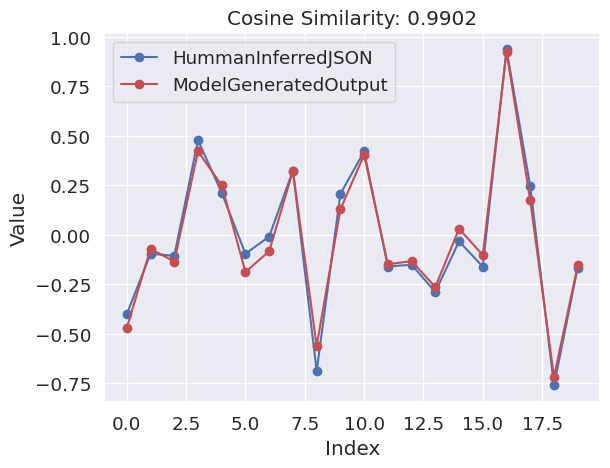

Cosine Similarity: 0.9902


In [147]:

vec_hummaninferred = np.array(testeval1_vectors[0])
vec_modelgenoutput = np.array(testeval1_vectors[1])

# Reshape vectors to be 2D arrays
vec_hummaninferred = vec_hummaninferred.reshape(1, -1)
vec_modelgenoutput = vec_modelgenoutput.reshape(1, -1)

# Calculate cosine similarity
similarity = cosine_similarity(vec_hummaninferred, vec_modelgenoutput)[0, 0]

# Plot the vectors
plt.plot(vec_hummaninferred[0], label='HummanInferredJSON', marker='o', linestyle='-', color='b')
plt.plot(vec_modelgenoutput[0], label='ModelGeneratedOutput', marker='o', linestyle='-', color='r')

# Add labels and title
plt.xlabel('Index')
plt.ylabel('Value')
plt.title(f'Cosine Similarity: {similarity:.4f}')

# Show the legend
plt.legend()

# Show the plot
plt.show()

print(f'Cosine Similarity: {similarity:.4f}')


In [24]:
test_eval2_data = [test_dataset[1]["HummanInferredJSON"], fintuned_res2]

# preproces the documents, and create TaggedDocuments
tagged_data = [TaggedDocument(words=word_tokenize(doc.lower()),
                              tags=[str(i)]) for i,
               doc in enumerate(test_eval2_data)]

# train the Doc2vec model
model = Doc2Vec(vector_size=20,
                min_count=10, epochs=80)
model.build_vocab(tagged_data)
model.train(tagged_data,
            total_examples=model.corpus_count,
            epochs=model.epochs)

# get the document vectors
testeval2_vectors = [model.infer_vector(
    word_tokenize(doc.lower())) for doc in test_eval2_data]

#  print the document vectors
for i, doc in enumerate(test_eval2_data):
    print("testeval2_vectors_doc", i+1, ":", doc)
    print("Vector:", testeval2_vectors[i])
    print()


testeval2_vectors_doc 1 : {"AccessToBuildingOtherThanDwellingsM1/M2":{"Objectives":{"SteppedAccess":{"Provisions":{"rules":[{"rule":"SteppedAccessSatifiesRequirementM1orM2","operator":"==","value":true,"conditions":[{"operator":"&&","condition":{"rule":"ALevelLandingProvidedAtTopAndBottomOfFlight","operator":"==","value":true}},{"operator":"&&","condition":{"rule":"TheUnobstructedLengthOfEachLanding","operator":">=","value":"1200mm"}},{"operator":"&&","condition":{"rule":"CorduroyHazardWarningSurfaceAtTopAndBottomLandingsOfSeriesOfFlights","operator":"==","value":true}},{"operator":"&&","condition":{"rule":"CorduroyHazardWarningSurfaeOnIntermediatelandingDepth","operator":"==","value":"400mm"}},{"operator":"&&","condition":{"rule":"NoDoorSwingAcrossLanding","operator":"==","value":true}},{"operator":"&&","condition":{"rule":"FlightsSurfaceWidthBetweenEnclosingWallsStringOrUpstands","operator":">=","value":"1.2m"}},{"operator":"&&","condition":{"rule":"NoSingleSteps","operator":"==","va

In [25]:
result2 = 1 - spatial.distance.cosine( testeval2_vectors[0], testeval2_vectors[1])
sim_results.append(result2)
print("model output evaluation (Test2) - cosine similarities:", result2)

model output evaluation (Test2) - cosine similarities: 0.7849072813987732


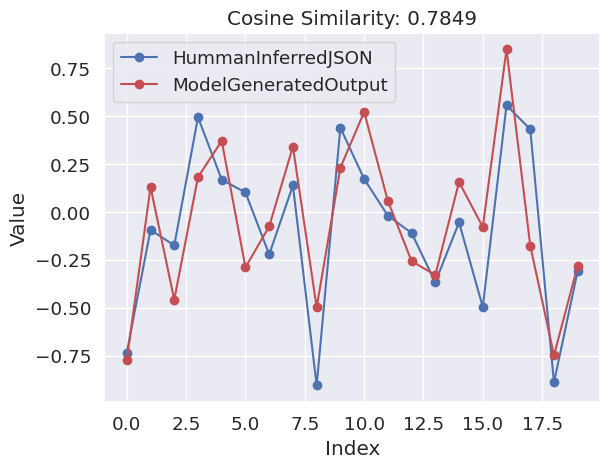

Cosine Similarity: 0.7849


In [146]:
vec_hummaninferred = np.array(testeval2_vectors[0])
vec_modelgenoutput = np.array(testeval2_vectors[1])

# Reshape vectors to be 2D arrays
vec_hummaninferred = vec_hummaninferred.reshape(1, -1)
vec_modelgenoutput = vec_modelgenoutput.reshape(1, -1)

# Calculate cosine similarity
similarity = cosine_similarity(vec_hummaninferred, vec_modelgenoutput)[0, 0]

# Plot the vectors
plt.plot(vec_hummaninferred[0], label='HummanInferredJSON', marker='o', linestyle='-', color='b')
plt.plot(vec_modelgenoutput[0], label='ModelGeneratedOutput', marker='o', linestyle='-', color='r')

# Add labels and title
plt.xlabel('Index')
plt.ylabel('Value')
plt.title(f'Cosine Similarity: {similarity:.4f}')

# Show the legend
plt.legend()

# Show the plot
plt.show()

print(f'Cosine Similarity: {similarity:.4f}')

In [27]:
# data_test_humman_inferred_json = [test_dataset[0]["HummanInferredJSON"], test_dataset[1]["HummanInferredJSON"],test_dataset[2]["HummanInferredJSON"], test_dataset[3]["HummanInferredJSON"], test_dataset[4]["HummanInferredJSON"]]
test_eval3_data = [test_dataset[2]["HummanInferredJSON"], fintuned_res3]

# preproces the documents, and create TaggedDocuments
tagged_data = [TaggedDocument(words=word_tokenize(doc.lower()),
                              tags=[str(i)]) for i,
               doc in enumerate(test_eval3_data)]

# train the Doc2vec model
model = Doc2Vec(vector_size=20,
                min_count=10, epochs=80)
model.build_vocab(tagged_data)
model.train(tagged_data,
            total_examples=model.corpus_count,
            epochs=model.epochs)

# get the document vectors
testeval3_vectors = [model.infer_vector(
    word_tokenize(doc.lower())) for doc in test_eval3_data]

#  print the document vectors
for i, doc in enumerate(test_eval3_data):
    print("testeval3_vectors_doc", i+1, ":", doc)
    print("Vector:", testeval3_vectors[i])
    print()


testeval3_vectors_doc 1 : {"GeneralProvisionsForMeansOfEscape":{"ProtectionOfEscapeRoutes":{"FireResistanceOfEnclosures":{"rules":[{"rule":"AllWallsPartitionsAndOtherEnclosuresNeedsToBeFireResisting","operator":"==","value":true,"conditions":[{"operator":"&&","condition":{"rule":"MeetProvisionsInThisDocument","operator":"==","value":true}}]},{"rule":"RoofsThatFormPartOfMeansOfEscape","operator":"==","value":true,"conditions":[{"operator":"&&","condition":{"rule":"AppropriatePerformanceGivenIn","operator":"==","value":"AppendixBofADB"}}]}]}}}}
Vector: [-0.19813481  0.19543639  0.0525974   0.22801025  0.12168105 -0.31519982
 -0.18032005  0.33427283 -0.36758485 -0.05175163  0.15340917  0.15843326
 -0.13090928 -0.19621778  0.10286877 -0.0517467   0.404199   -0.16588572
 -0.38430774 -0.19538848]

testeval3_vectors_doc 2 : {"GeneralProvisionsForMeansOfEscape":{"ProtectionOfEscapeRoutes":{"FireResistanceOfEnclosures":{"rules":[{"rule":"AllWallsPartitionsAndOtherEnclosures","operator":"==","va

In [101]:
result3 = 1 - spatial.distance.cosine( testeval3_vectors[0], testeval3_vectors[1])
sim_results.append(result3)
print("model output evaluation (Test3) - cosine similarities:", result3)

model output evaluation (Test3) - cosine similarities: 0.9966498017311096


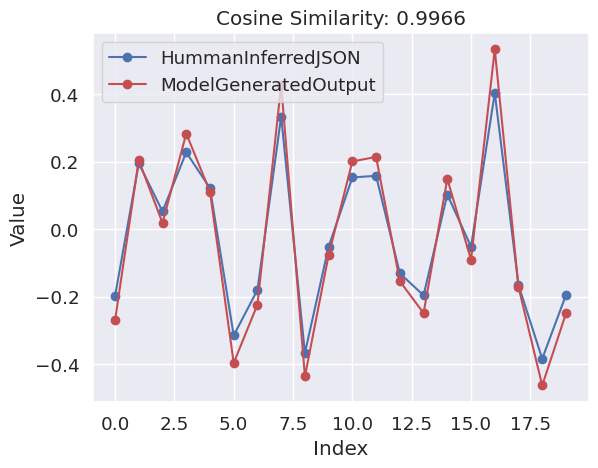

Cosine Similarity: 0.9966


In [145]:
vec_hummaninferred = np.array(testeval3_vectors[0])
vec_modelgenoutput = np.array(testeval3_vectors[1])

# Reshape vectors to be 2D arrays
vec_hummaninferred = vec_hummaninferred.reshape(1, -1)
vec_modelgenoutput = vec_modelgenoutput.reshape(1, -1)

# Calculate cosine similarity
similarity = cosine_similarity(vec_hummaninferred, vec_modelgenoutput)[0, 0]

# Plot the vectors
plt.plot(vec_hummaninferred[0], label='HummanInferredJSON', marker='o', linestyle='-', color='b')
plt.plot(vec_modelgenoutput[0], label='ModelGeneratedOutput', marker='o', linestyle='-', color='r')

# Add labels and title
plt.xlabel('Index')
plt.ylabel('Value')
plt.title(f'Cosine Similarity: {similarity:.4f}')

# Show the legend
plt.legend()

# Show the plot
plt.show()

print(f'Cosine Similarity: {similarity:.4f}')

In [30]:
# data_test_humman_inferred_json = [test_dataset[0]["HummanInferredJSON"], test_dataset[1]["HummanInferredJSON"],test_dataset[2]["HummanInferredJSON"], test_dataset[3]["HummanInferredJSON"], test_dataset[4]["HummanInferredJSON"]]
test_eval4_data = [test_dataset[3]["HummanInferredJSON"], fintuned_res4]

# preproces the documents, and create TaggedDocuments
tagged_data = [TaggedDocument(words=word_tokenize(doc.lower()),
                              tags=[str(i)]) for i,
               doc in enumerate(test_eval4_data)]

# train the Doc2vec model
model = Doc2Vec(vector_size=20,
                min_count=10, epochs=80)
model.build_vocab(tagged_data)
model.train(tagged_data,
            total_examples=model.corpus_count,
            epochs=model.epochs)

# get the document vectors
testeval4_vectors = [model.infer_vector(
    word_tokenize(doc.lower())) for doc in test_eval4_data]

#  print the document vectors
for i, doc in enumerate(test_eval4_data):
    print("testeval4_vectors_doc", i+1, ":", doc)
    print("Vector:", testeval4_vectors[i])
    print()


testeval4_vectors_doc 1 : {"GeneralProvisionsForMeansOfEscape":{"MechanicalVentilationAndAirConditioningSystems":{"rules":[{"rule":"SystemOfMechanicalVentilationDesignedToEnsure","operator":"==","value":"FireBreakOutDuctworkNotAssistInTransferringFireAndSmokeThroughBuilding"},{"rule":"ExhaustPointsSitedNotJeopardizeBuilding","operator":"==","value":true},{"rule":"VentilationDuctsSupplyingOrExtractingAirDirectlyToOrFromProtectedEscapeRoute","operator":"!=","value":"ServeOtherAreas"},{"rule":"SeparateVentilationSystemProvidedForProtectedStairway","operator":"==","value":true},{"rule":"DuctworkSystemServesMoreThanOnePartOfSubDividedEscapeRoute","operator":"==","value":true},{"rule":"DuctworkEntersEachSectionOfEscapeRoute","operator":"==","value":true,"conditions":[{"operator":"&&","condition":{"rule":"FireAndSmokeDamperProvided","operator":"==","value":true}}]},{"rule":"FireAndSmokeDamperOperatedBy","operator":"==","value":["SmokeDetector","SuitableFireDetectionSystem"]},{"rule":"FireDamp

In [31]:
result4 = 1 - spatial.distance.cosine( testeval4_vectors[0], testeval4_vectors[1])
sim_results.append(result4)
print("model output evaluation (Test4) - cosine similarities:", result4)

model output evaluation (Test4) - cosine similarities: 0.9982369542121887


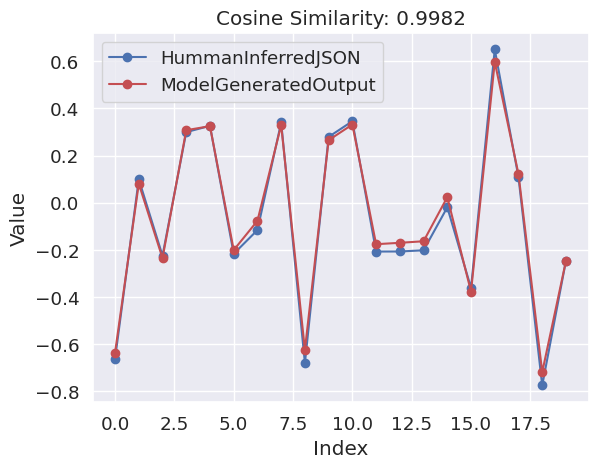

Cosine Similarity: 0.9982


In [148]:
vec_hummaninferred = np.array(testeval4_vectors[0])
vec_modelgenoutput = np.array(testeval4_vectors[1])

# Reshape vectors to be 2D arrays
vec_hummaninferred = vec_hummaninferred.reshape(1, -1)
vec_modelgenoutput = vec_modelgenoutput.reshape(1, -1)

# Calculate cosine similarity
similarity = cosine_similarity(vec_hummaninferred, vec_modelgenoutput)[0, 0]

# Plot the vectors
plt.plot(vec_hummaninferred[0], label='HummanInferredJSON', marker='o', linestyle='-', color='b')
plt.plot(vec_modelgenoutput[0], label='ModelGeneratedOutput', marker='o', linestyle='-', color='r')

# Add labels and title
plt.xlabel('Index')
plt.ylabel('Value')
plt.title(f'Cosine Similarity: {similarity:.4f}')

# Show the legend
plt.legend()

# Show the plot
plt.show()

print(f'Cosine Similarity: {similarity:.4f}')

In [33]:
test_eval5_data = [test_dataset[4]["HummanInferredJSON"], fintuned_res5]

# preproces the documents, and create TaggedDocuments
tagged_data = [TaggedDocument(words=word_tokenize(doc.lower()),
                              tags=[str(i)]) for i,
               doc in enumerate(test_eval5_data)]

# train the Doc2vec model
model = Doc2Vec(vector_size=20,
                min_count=10, epochs=80)
model.build_vocab(tagged_data)
model.train(tagged_data,
            total_examples=model.corpus_count,
            epochs=model.epochs)

# get the document vectors
testeval5_vectors = [model.infer_vector(
    word_tokenize(doc.lower())) for doc in test_eval5_data]

#  print the document vectors
for i, doc in enumerate(test_eval5_data):
    print("testeval5_vectors_doc", i+1, ":", doc)
    print("Vector:", testeval5_vectors[i])
    print()


testeval5_vectors_doc 1 : {"FacilitiesInBuildingsOtherThanDwellingsM1":{"Objectives":{"AudienceAndSpectatorFacilities":{"Provisions":{"rules":[{"rule":"AudienceANdSpectatorFacilitySatisfyRequirementM1","operator":"==","value":true,"conditions":[{"operator":"&&","condition":{"rule":"RouteToWheelChairSpacesIsAccessibleByWheelChairUsers","operator":"==","value":true}},{"operator":"&&","condition":{"rule":"SteppedAccessRoutesToAudienceSeatingAreProvidedWithFixedHandRails","operator":"==","value":true}},{"operator":"&&","condition":{"rule":"SteppedAccessRoutesToAudienceSeatingAreProvidedWithFixedHandRails","operator":"==","value":true}},{"operator":"&&","condition":{"rule":"MinimumNumberOfPermanentAndRemovableSpacesProvidedForWheelChairUsers","operator":"==","value":"Table3"}},{"operator":"&&","condition":{"rule":"WheelChairSpacesProvidedInPairsWithStandardSeatingOnAtLeastOneSide","operator":"==","value":true}},{"operator":"&&","condition":{"rule":"WheelChairSpacesProvidedInPairsWithStandar

In [34]:
result5 = 1 - spatial.distance.cosine( testeval5_vectors[0], testeval5_vectors[1])
sim_results.append(result5)
print("model output evaluation (Test5) - cosine similarities:", result5)

model output evaluation (Test5) - cosine similarities: 0.9892600774765015


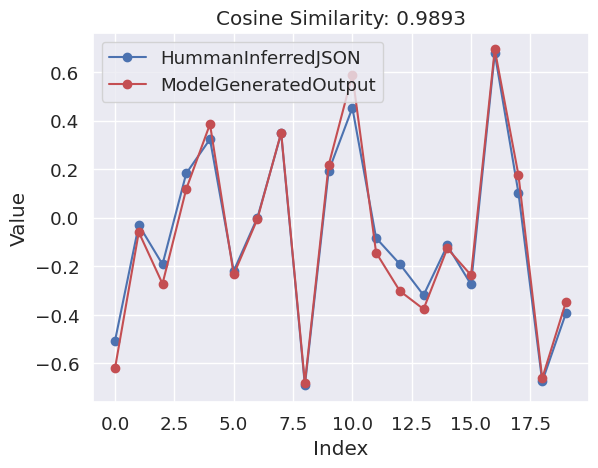

Cosine Similarity: 0.9893


In [149]:
vec_hummaninferred = np.array(testeval5_vectors[0])
vec_modelgenoutput = np.array(testeval5_vectors[1])

# Reshape vectors to be 2D arrays
vec_hummaninferred = vec_hummaninferred.reshape(1, -1)
vec_modelgenoutput = vec_modelgenoutput.reshape(1, -1)

# Calculate cosine similarity
similarity = cosine_similarity(vec_hummaninferred, vec_modelgenoutput)[0, 0]

# Plot the vectors
plt.plot(vec_hummaninferred[0], label='HummanInferredJSON', marker='o', linestyle='-', color='b')
plt.plot(vec_modelgenoutput[0], label='ModelGeneratedOutput', marker='o', linestyle='-', color='r')

# Add labels and title
plt.xlabel('Index')
plt.ylabel('Value')
plt.title(f'Cosine Similarity: {similarity:.4f}')

# Show the legend
plt.legend()

# Show the plot
plt.show()

print(f'Cosine Similarity: {similarity:.4f}')

In [37]:
print("Cosine Similarity Distribution: ")
print(f"min / max: {min(sim_results)}, {max(sim_results)}")
print(f"mean / median: {np.mean(sim_results)}, {np.median(sim_results)}")

Cosine Similarity Distribution: 
min / max: 0.7849072813987732, 0.9982369542121887
mean / median: 0.951852536201477, 0.9902085661888123


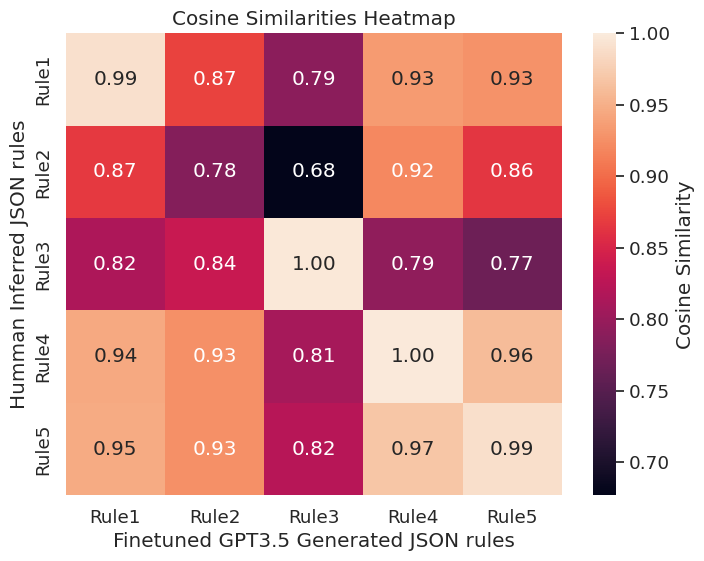

In [144]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt

#Array of vector representation of model generated output
x = np.array([testeval1_vectors[0], testeval2_vectors[0], testeval3_vectors[0], testeval4_vectors[0], testeval5_vectors[0]])

#Array of vector representation of ground truth (Humman Inferred JSON)
y = np.array([testeval1_vectors[1], testeval2_vectors[1], testeval3_vectors[1], testeval4_vectors[1], testeval5_vectors[1]])

labels =["Rule1", "Rule2", "Rule3", "Rule4", "Rule5"]


# Calculate cosine similarity
cosine_similarities = cosine_similarity(x, y)

# Create a heatmap
sns.set(font_scale=1.2)
plt.figure(figsize=(8, 6))
ax = sns.heatmap(cosine_similarities, annot=True, fmt=".2f", vmax=1, xticklabels=labels, yticklabels=labels)

# Customize the plot
plt.title("Cosine Similarities Heatmap")
plt.xlabel("Finetuned GPT3.5 Generated JSON rules")
plt.ylabel("Humman Inferred JSON rules")
cbar = ax.collections[0].colorbar
cbar.set_label("Cosine Similarity")

# Show the plot
plt.show()


# Few-shots prompt evaluation

**Long Prompt Approach**

In [1]:
oneshotlongpromptoutput = """{"InclusiveDesign":{"OverallConsiderations":{"DeafOrHardOfHearingPeople":{"rules":[{"rule":"FlashingBeaconsRequiredIn","operator":"==","objectTypes":["toilets"],"conditions":[{"operator":"&&","condition":{"rule":"AreasIdentifiedAsPlacesWherePeopleMayBeAlone","operator":"==","value":true}}]},{"rule":"!","operator":"!","value":"SuitableForAllPupils","conditions":[{"operator":"&&","condition":{"rule":"BuddySystemsOrVibratingPagers","operator":"==","value":"Considered"}},{"operator":"||","condition":{"rule":"VibratingPagersLinkedToFireAlarm","operator":"==","value":true}}]}]},"ManagementOfEvacuation":{"HorizontalCirculation":{"Doors":{"rules":[{"rule":"UnobstructedSpaceOnPullSide","operator":"==","value":"300mm"},{"rule":"OpenDoorWithClosedFist","operator":"==","value":true},{"rule":"VisualContrastBetweenFurnitureAndDoor","operator":"==","value":true},{"rule":"VisualContrastBetweenDoorFrameAndSurroundingWall","operator":"==","value":true},{"rule":"ClearOpeningWidthMeetsRequirementsIn","operator":"==","value":"Table5"},{"rule":"EmergencyBreakGlassPanelsAndDoorReleasesMountedBetween","operator":"IN","values":["1000mm","1200mm"],"conditions":[{"operator":"&&","condition":{"rule":"AccessibleForDisabledPeople"}}]},{"rule":"VisionPanelsProvidedInDoorsAndSidePanelsWiderThan","operator":"==","value":"450mm","conditions":[{"operator":"&&","condition":{"rule":"ZoneOfVisibilityProvidedBetween","operator":"==","value":"500mm","value2":"1500mm"}},{"operator":"&&","condition":{"rule":"ZoneOfVisibilityInterruptedBetween","operator":"==","value":"800mm","value2":"1150mm"}}]}]},"DoorClosers":{"rules":[{"rule":"DoorClosersOnlyProvidedWhereEssential","operator":"==","value":true},{"rule":"OpeningForceAtLeadingEdgeOfDoorFrom0To30IsNotMoreThan","operator":"<=","value":"30N"},{"rule":"OpeningForceAtLeadingEdgeOfDoorFrom30To60IsNotMoreThan","operator":"<=","value":"22.5N"},{"rule":"AlternativeMethodsOfCreatingEasilyAccessibleRoutesShouldBeConsidered","operator":"==","value":true,"conditions":[{"operator":"||","condition":{"rule":"HoldOpenDevices","operator":"==","value":true}},{"operator":"||","condition":{"rule":"Automation","operator":"==","value":true}}]}]},"VerticalCirculation":{"Stairs":{"rules":[{"rule":"LevelLandingAtTopAndBottomOfSteps","operator":"==","value":true,"conditions":[{"operator":"&&","condition":{"rule":"UnobstructedLengthOfNotLessThan","operator":">=","value":"1200mm"}}]},{"rule":"NosingContrastsWithMainStepToDepthOf","operator":"==","value":"55mm","conditions":[{"operator":"!","condition":{"rule":"PreferableToHaveStepsWithoutNosings","operator":"==","value":true}},{"operator":"&&","condition":{"rule":"NosingProjectsNoMoreThan","operator":"<=","value":"25mm"},"value2":"tread below"}}]},{"rule":"MaximumRiseOf","operator":"<=","value":"160mm"},{"rule":"MinimumGoingOf","operator":">=","value":"280mm"},{"rule":"ContinuousHandrailToEachSideOfFlightAndLandings","operator":"==","value":true}]}},"Refuges":{"rules":[{"rule":"ProvidedWithinProtectedStairwayLobbyAtEachStorey","operator":"==","value":true},{"rule":"EffectiveAndAccessibleCommunicationBetweenRefugeAndEvacuationOrganizers","operator":"==","value":true},{"rule":"RefugesEnabledByEmergencyVoiceCommunicationSystemComplyingWith","operator":"==","value":"BS5839Part9","conditions":[{"operator":"&&","condition":{"rule":"OutstationsLocatedInEachRefuge","operator":"==","value":true}},{"operator":"&&","condition":{"rule":"IncomingStationLocatedInSameLocationAsMainFireAlarmPanel","operator":"==","value":true}}]},{"rule":"LocatedToAllowEasyAccessToStairsAndOrEvacuationLifts"},{"rule":"ProtectedFromSmokeAndFire","operator":"==","value":true},{"rule":"SimpleAccessibleSignageIndicatingRefugeAndProvidingInstructions","operator":"==","value":true},{"rule":"FoldDownChairProvidedInRefuge"},{"rule":"RefugeTypeIsSatisfactory","operator":"IN","objectTypes":["enclosure","open air"],"conditions":[{"condition":{"rule":"ProtectedOrRemoteFromFireRisk","operator":"==","value":true}},{"operator":"&&","condition":{"rule":"OwnMeansOfEscape","operator":"==","value":true}}]},{"rule":"!","operator":"!","value":"ReduceWidthOfEscapeRoute","conditions":[{"operator":"&&","condition":{"rule":"ObstructFlowOfPeopleEscaping","operator":"==","value":false}}]}]}}}}}}"""

In [2]:
onshotHummanInferredJSON = """{"InclusiveDesign":{"OverallConsiderations":{"rules":[{"rule":"FlashingBeaconsAreRequired","operator":"==","value":["Toilets","PlacesPeopleMayBeOnTheirOwn"]}]},"HorizontalCirculation":{"Doors":{"OnEvacuationRoutes":{"MustBePulled":{"rules":[{"rule":"UnObstructedSpace","operator":"==","value":"300mm","conditions":[{"operator":"&&","condition":{"rule":"BetweenLeadingEdgeAndReturnWall","operator":"==","value":true}}]}]},"rules":[{"rule":"PossibleToOperateWithcloseFirst","operator":"==","value":true},{"rule":"DoorFunitureIsVisuallyContrastwithDoor","operator":"==","value":true},{"rule":"DoorFrameIsVisuallyContrastwithSoroundingWall","operator":"==","value":true},{"rule":"ClearOpeneingWith","operator":"==","value":"RequirementSetOutinTable5"},{"rule":"EmergencyBreakGlassPannelAndDoorReleaseMountedFromFloorBetween","operator":"==","value":["1000mm","1200mm"],"conditions":[{"condition":{"rule":"DoorLeavesAndSidePannelWidth","operator":">","value":"450mm"}},{"rule":"VisonPannelProvisionTowardLeadingEdgeOfDoor","operator":"==","value":true}]}]}},"DoorClosers":{"rules":[{"rule":"ProvidedWhereEssential","operator":"==","value":true},{"rule":"OpeningForceAtLeadingEdge0_30","operator":"<=","value":"30N"},{"rule":"OpeningForceAtLeadingEdge30_60","operator":"<=","value":"22.5N"}]}},"VerticalCirculatiom":{"Stairs":{"rules":[{"rule":"LandingAtTheTop","operator":"==","value":true},{"rule":"BottomOfTheSteps","operator":"==","value":true,"conditions":[{"condition":{"rule":"UnobstructedLength","operator":">=","value":"1200mm"}}]},{"rule":"NosingVisuallyContrastingWithMainStepToDepth","operator":"==","value":"55mm"},{"rule":"NosingProjectOverTreadBelow","operator":">=","value":"25mm"},{"rule":"MaximumRise","operator":"==","value":"160mm"},{"rule":"MinimumGoing","operator":"==","value":"280mm"},{"rule":"ContinousHandRailToEachSide","operator":"==","value":["Flight","Landings"]}]},"Refuges":{"rules":[{"rule":"ProvidedWithEachProtectedStairwayLobby","operator":"==","value":true},{"rule":"EnableEffectiveAndAccessibleCommunication","operator":"==","value":true},{"rule":"Located","operator":"!","value":["Stairs","EvacuationLifts"]},{"rule":"ProtectedFrom","operator":"==","value":["Smoke","Fire"]},{"rule":"HasAcessibleSignageToIndicate","operator":"==","value":["RefugeArea","SimpleInstructions"]},{"rule":"IncludeFoldDownChair","operator":"==","value":true},{"rule":"ReduceEscapeRouteWidth","operator":"==","value":false},{"rule":"ObstructFlowOfPeopleEscaping","operator":"==","value":false}]}}}}"""

In [13]:
onshotlongprompt_eval_data = [oneshotlongpromptoutput, onshotHummanInferredJSON]

# preproces the documents, and create TaggedDocuments
tagged_data = [TaggedDocument(words=word_tokenize(doc.lower()),
                              tags=[str(i)]) for i,
               doc in enumerate(onshotlongprompt_eval_data)]

# train the Doc2vec model
model = Doc2Vec(vector_size=20,
                min_count=10, epochs=80)
model.build_vocab(tagged_data)
model.train(tagged_data,
            total_examples=model.corpus_count,
            epochs=model.epochs)

# get the document vectors
onshotlongprompteval_vectors = [model.infer_vector(
    word_tokenize(doc.lower())) for doc in onshotlongprompt_eval_data]

#  print the document vectors
for i, doc in enumerate(onshotlongprompt_eval_data):
    print("onshotlongprompteval_vectors_doc", i+1, ":", doc)
    print("Vector:", onshotlongprompteval_vectors[i])
    print()


onshotlongprompteval_vectors_doc 1 : {"InclusiveDesign":{"OverallConsiderations":{"DeafOrHardOfHearingPeople":{"rules":[{"rule":"FlashingBeaconsRequiredIn","operator":"==","objectTypes":["toilets"],"conditions":[{"operator":"&&","condition":{"rule":"AreasIdentifiedAsPlacesWherePeopleMayBeAlone","operator":"==","value":true}}]},{"rule":"!","operator":"!","value":"SuitableForAllPupils","conditions":[{"operator":"&&","condition":{"rule":"BuddySystemsOrVibratingPagers","operator":"==","value":"Considered"}},{"operator":"||","condition":{"rule":"VibratingPagersLinkedToFireAlarm","operator":"==","value":true}}]}]},"ManagementOfEvacuation":{"HorizontalCirculation":{"Doors":{"rules":[{"rule":"UnobstructedSpaceOnPullSide","operator":"==","value":"300mm"},{"rule":"OpenDoorWithClosedFist","operator":"==","value":true},{"rule":"VisualContrastBetweenFurnitureAndDoor","operator":"==","value":true},{"rule":"VisualContrastBetweenDoorFrameAndSurroundingWall","operator":"==","value":true},{"rule":"Clear

In [7]:
onshotlongprompt_result = 1 - spatial.distance.cosine( onshotlongprompteval_vectors[0], onshotlongprompteval_vectors[1])
# sim_results.append(onshotlongprompt_result)
print("model output evaluation (onshotlongprompt) - cosine similarities:", onshotlongprompt_result)

model output evaluation (onshotlongprompt) - cosine similarities: 0.36594340205192566


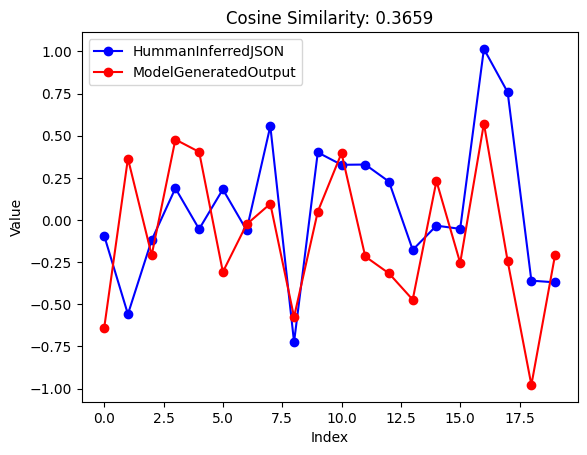

Cosine Similarity: 0.3659


In [9]:
vec_hummaninferred = np.array(onshotlongprompteval_vectors[0])
vec_modelgenoutput = np.array(onshotlongprompteval_vectors[1])

# Reshape vectors to be 2D arrays
vec_hummaninferred = vec_hummaninferred.reshape(1, -1)
vec_modelgenoutput = vec_modelgenoutput.reshape(1, -1)

# Calculate cosine similarity
similarity = cosine_similarity(vec_hummaninferred, vec_modelgenoutput)[0, 0]

# Plot the vectors
plt.plot(vec_hummaninferred[0], label='HummanInferredJSON', marker='o', linestyle='-', color='b')
plt.plot(vec_modelgenoutput[0], label='ModelGeneratedOutput', marker='o', linestyle='-', color='r')

# Add labels and title
plt.xlabel('Index')
plt.ylabel('Value')
plt.title(f'Cosine Similarity: {similarity:.4f}')

# Show the legend
plt.legend()

# Show the plot
plt.show()

print(f'Cosine Similarity: {similarity:.4f}')

**Using the short prompt approach**

In [12]:
shotpromtoutput= """{"InclusiveDesign":{"VerticalCirculation":{"Stairs":{"rules":[{"rule":"LevelLandingsAtTopAndBottom","operator":"==","value":true},{"rule":"UnobstructedLengthOfLanding","operator":">=","value":"1200mm"},{"rule":"VisuallyContrastingNosing","operator":">=","value":"55mm"},{"rule":"NosingProjectionOverTreadBelow","operator":">=","value":"25mm"},{"rule":"MaximumRise","operator":"<=","value":"160mm"},{"rule":"MinimumGoing","operator":">=","value":"280mm"},{"rule":"SuitableHandrailsToEachSide","operator":">=","value":"1"},{"rule":"CarryDownProcedures","operator":"==","value":true},{"rule":"AccessibleEvacuationLift","operator":"==","value":true}]}}}}}"""


In [15]:
shortprompthumaninferred= """{"InclusiveDesign":{"VerticalCirculation":{"Stairs":{"rules":[{"rule":"LandingAtTheTop","operator":"==","value":true},{"rule":"BottomOfTheSteps","operator":"==","value":true,"conditions":[{"condition":{"rule":"UnobstructedLength","operator":">=","value":"1200mm"}}]},{"rule":"NosingVisuallyContrastingWithMainStepToDepth","operator":"==","value":"55mm"},{"rule":"NosingProjectOverTreadBelow","operator":">=","value":"25mm"},{"rule":"MaximumRise","operator":"==","value":"160mm"},{"rule":"MinimumGoing","operator":"==","value":"280mm"},{"rule":"ContinousHandRailToEachSide","operator":"==","value":["Flight","Landings"]}]}}}}"""

In [16]:
shortgprompt_eval_data = [shotpromtoutput, shortprompthumaninferred]

# preproces the documents, and create TaggedDocuments
tagged_data = [TaggedDocument(words=word_tokenize(doc.lower()),
                              tags=[str(i)]) for i,
               doc in enumerate(shortgprompt_eval_data)]

# train the Doc2vec model
model = Doc2Vec(vector_size=20,
                min_count=10, epochs=80)
model.build_vocab(tagged_data)
model.train(tagged_data,
            total_examples=model.corpus_count,
            epochs=model.epochs)

# get the document vectors
shortprompteval_vectors = [model.infer_vector(
    word_tokenize(doc.lower())) for doc in shortgprompt_eval_data]

#  print the document vectors
for i, doc in enumerate(shortgprompt_eval_data):
    print("onshotlongprompteval_vectors_doc", i+1, ":", doc)
    print("Vector:", shortprompteval_vectors[i])
    print()

onshotlongprompteval_vectors_doc 1 : {"InclusiveDesign":{"VerticalCirculation":{"Stairs":{"rules":[{"rule":"LevelLandingsAtTopAndBottom","operator":"==","value":true},{"rule":"UnobstructedLengthOfLanding","operator":">=","value":"1200mm"},{"rule":"VisuallyContrastingNosing","operator":">=","value":"55mm"},{"rule":"NosingProjectionOverTreadBelow","operator":">=","value":"25mm"},{"rule":"MaximumRise","operator":"<=","value":"160mm"},{"rule":"MinimumGoing","operator":">=","value":"280mm"},{"rule":"SuitableHandrailsToEachSide","operator":">=","value":"1"},{"rule":"CarryDownProcedures","operator":"==","value":true},{"rule":"AccessibleEvacuationLift","operator":"==","value":true}]}}}}}
Vector: [-0.43149638  0.08313569 -0.27979958  0.4105288  -0.0539638  -0.18432654
 -0.09637841  0.3288552  -0.4531036   0.31238073  0.43135017  0.0171313
 -0.22772011 -0.04475856  0.27554938 -0.14659536  0.53506535 -0.07954939
 -0.5955526  -0.13899831]

onshotlongprompteval_vectors_doc 2 : {"InclusiveDesign":{"

In [17]:
shortprompt_result = 1 - spatial.distance.cosine( shortprompteval_vectors[0], shortprompteval_vectors[1])
# sim_results.append(onshotlongprompt_result)
print("model output evaluation (onshotlongprompt) - cosine similarities:", shortprompt_result)

model output evaluation (onshotlongprompt) - cosine similarities: 0.9972629547119141


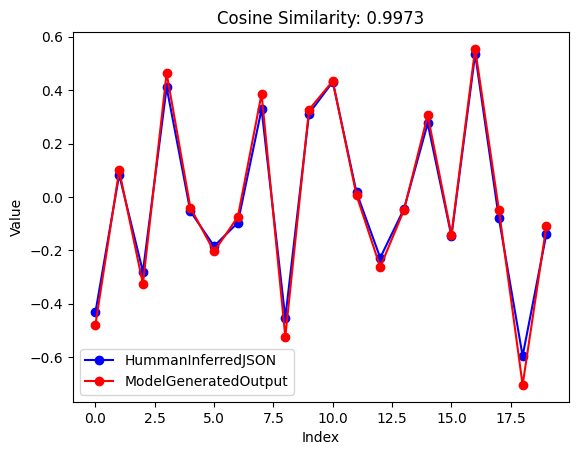

Cosine Similarity: 0.9973


In [18]:
vec_hummaninferred = np.array(shortprompteval_vectors[0])
vec_modelgenoutput = np.array(shortprompteval_vectors[1])

# Reshape vectors to be 2D arrays
vec_hummaninferred = vec_hummaninferred.reshape(1, -1)
vec_modelgenoutput = vec_modelgenoutput.reshape(1, -1)

# Calculate cosine similarity
similarity = cosine_similarity(vec_hummaninferred, vec_modelgenoutput)[0, 0]

# Plot the vectors
plt.plot(vec_hummaninferred[0], label='HummanInferredJSON', marker='o', linestyle='-', color='b')
plt.plot(vec_modelgenoutput[0], label='ModelGeneratedOutput', marker='o', linestyle='-', color='r')

# Add labels and title
plt.xlabel('Index')
plt.ylabel('Value')
plt.title(f'Cosine Similarity: {similarity:.4f}')

# Show the legend
plt.legend()

# Show the plot
plt.show()

print(f'Cosine Similarity: {similarity:.4f}')